# Introduction

The following is an analysis of the data collected through a survey of
participants in [RocDev](https://rocdev.org/), a community of professionals
in disciplines related to software development in the greater Rochester
area.  The information collected concerned (1) employment (2) compensation, 
(3) demographics, and (4) employers' responses to the COVID-19 pandemic.
Thank you to everyone who took the time to complete it.  We hope 
that the information will be useful.

## Open Analysis

While we aren't publishing the raw data this year, this analysis is
completely open, using a Jupyter notebook to show exactly what data is
available and how figures were generated.  If you would like to run
additional analysis on this data not included below, please get in touch
with us via the RocDev Slack instance.  You can also submit a pull 
request with changes made to this notebook.

## Limitations

Before diving into the data itself, we should discuss some of its
limitations.  First, it's important to note that this data is what's known
as _convenience sample,_ focused on the RocDev community itself, rather 
than an attempt to randomly sample from all software professionals in the
Rochester area.  This limits the type of statistical inferences that can be
drawn, because RocDev participants (and others who may have learned of the
survey through word of mouth) may differ from the broader population in 
systematic ways.  Or, put another way, making inferences about the 
_entire_ software development community in and around Rochester requires
making assumptions that unlikely to be completely accurate, because whether
or not people filled out the survey could be correlated with the variables 
we're interested in.

Second, even though we had (exactly) 100 responses this year, this is still
a relatively small sample for many types of statistical analysis. For
example, only 6 respondents work in testing, 3 had PhDs, and 2 worked for
government.  These data limitations prevent statistically reliable 
cross-group comparisons in many cases.


## Software Dependencies

As software development professionals, it's appropriate to say a quick
"thank you" to colleagues in the open source and data science communities
for the software used to do this analysis!  For this small-time analysis
project, we used Python, Pandas, MatPlotLib, Seaborn, and Jupyter.
Thank you to all the developers who contributed to these projects!

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import math
import statsmodels.formula.api as sm

# Importing and Processing Data

First, we'll import the data and give the columns shorter mnemonic names
that are more practical to refer to in source code.  Then we'll prepare the data
for statistical analysis by coercing data into the correct types (i.e., numbers,
categories, and yes/no questions).

The "cleaned" version of the data just removes a few outliers that were obviously
errors.  For example, even putting aside the human need for sleep, it's not
possible work more than 168 hours in a week, so we can be confident data that
violates this constraint was entered in error, and the data removed.

In [2]:
as_imported = pd.read_csv("2020-cleaned.csv")
data = pd.read_csv("2020-cleaned.csv")
descriptions = data.columns
data.columns = [
    'timestamp', # When the survey was completed (from Google Forms)
    'consent', # important for data consent, irrelevant for analysis
    'org_type', # Public, private, or self-employed?
    'job_type', # Regular (i.e., W-2) employee or contractor?
    'org_size', # Approximately how many people work for your employer worldwide?
    'org_where', # Where is your employer located?
    'job_title', # What is your official job title?
    'job_role', # which of the following best describes your role?
    'job_description', # Please write a short description of what you do.
    'job_tenure', # How many years have you been with your current employer?
    'job_supervisor', # Do people report directly to you?
    'job_remote', # Did you work remotely (Pre-COVID)?
    'side_job', # Do you have a second job or side business?
    'tech_tenure', # How many years have you worked in the technology industry?
    'tech_jobs', # How many different jobs have you had in that time?
    'job_pay', # What is your approximate annual salary (in thousands) including bonuses?
    'job_when_negotiated', # What year was your current pay set?
    'job_hours', # How many yours do you work in an average week?
    'job_benefits', # What other kinds of compensation and benefits does your employer provide?
    'job_vacation', # If your employer offers paid vacation, how many paid days off per year?
    'side_job_pay', # If you have a second job or do outside contract work, approx. how much do you make on the side?
    'covid_actions', # What action(s) did your employer(s) take in response to COVID?
    'covid_return', # If you work(ed) remotely in response to COVID, when do you expect to be "back in the office?"
    'covid_satisfied', # How satisfied are you with your employer's response to the COVID-19 pandemic?
    'covid_changes', # Which of the following describe your personal experience with employment and COVID-19?
    'domicile', # Where do you live?  (Multiple choice general areas)
    'education', # What is the highest degree you have received?
    'school', # At which School/University did you receive this degree?
    'gender', # Gender
    'race', # Race
    'misc', # Do you identify with any of the following?
    'comments' # Do you have anything else to add?
]
as_imported.columns = data.columns

# This is just changing the types of a few columns from text to discrete categories.
data['job_type'] = data['job_type'].astype('category')
data['org_where'] = data['org_where'].astype('category')
data['job_role'] = data['job_role'].astype('category')
data['job_supervisor'] = data['job_supervisor'].astype('category')
data['job_remote'] = data['job_remote'].astype('category')
data['side_job'] = data['side_job'].astype('category')
data['domicile'] = data['domicile'].astype('category')
data['education'] = data['education'].astype('category')
data['gender'] = data['gender'].astype('category')
data['race'] = data['race'].astype('category')

# This was a little bit more complicated for columns with multiple checkboxes,
# because they were both comma separated and contained columns.  There were only
# a few, so I just did quick functions to organize the data.
def map_benefits_dummies(input):
    if isinstance(input, str):
        benefits = []
        if "Health Insurance" in input:
            benefits.append("benefits_health")
        if "Dental" in input:
            benefits.append("benefits_dental")
        if "Vision" in input:
            benefits.append("benefits_vision")
        if "HSA" in input:
            benefits.append("benefits_hsa")
        if "401k" in input:
            benefits.append("benefits_retirement_matching")
        if "Equity" in input:
            benefits.append("benefits_equity_options")
        if "Profit Sharing" in input:
            benefits.append("benefits_profit_sharing")
        if "Tuition" in input:
            benefits.append("benefits_tuition")
        return benefits
    return ['benefits_na']

def map_covid_action_dummies(input):
    if isinstance(input, str):
        actions = []
        if "Remote Work" in input:
            actions.append("covid_remote")
        if "Reduced Pay" in input:
            actions.append("covid_pay_cut")
        if "Furlough" in input:
            actions.append("covid_furlough")
        if "Layoffs" in input:
            actions.append("covid_layoffs")
        if "Hiring" in input:
            actions.append("covid_no_hire")
        if "Reduced Hours" in input:
            actions.append("covid_less_work")
        if "Cross-Training" in input:
            actions.append("covid_cross_train")
        return actions
    return ['covid_action_none']

def map_covid_changes_dummies(input):
    if isinstance(input, str):
        changes = []
        if "Increased hours" in input:
            changes.append("covid_more_work")
        if "laid off" in input:
            changes.append("covid_laid_off")
        if "trouble finding" in input:
            changes.append("covid_unemployed")
        if "several" in input:
            changes.append("covid_chaotic")
        return changes
    return ['covid_changes_none']

def map_misc_dummies(input):
    if isinstance(input, str):
        changes = []
        if "LGBT" in input:
            changes.append("misc_lgbt")
        if "disability" in input:
            changes.append("misc_disability")
        if "veteran" in input:
            changes.append("misc_veteran")
        if "Citizen" in input:
            changes.append("misc_foreigner")
        if "Parent" in input:
            changes.append("misc_parent")
        return changes
    return ['misc_none']

benefits_dummies = pd.get_dummies(data['job_benefits'].map(map_benefits_dummies).apply(pd.Series).stack()).sum(level=0)
covid_action_dummies = pd.get_dummies(data['covid_actions'].map(map_covid_action_dummies).apply(pd.Series).stack()).sum(level=0)
covid_changes_dummies = pd.get_dummies(data['covid_changes'].map(map_covid_changes_dummies).apply(pd.Series).stack()).sum(level=0)
misc_dummies = pd.get_dummies(data['misc'].map(map_misc_dummies).apply(pd.Series).stack()).sum(level=0)
data = data.join(benefits_dummies).join(covid_action_dummies).join(covid_changes_dummies).join(misc_dummies)

# Composite columns
data['job_avg_tenure'] = data.apply(lambda row: row.tech_tenure / row.tech_jobs, axis = 1)
data['log_org_size'] = data.apply(lambda row: math.log10(row.org_size), axis = 1)

In [3]:
# This is just a function to get consistent pie charts without repeating
# formatting code, etc...
def mmpie(data,col_name,title,start_angle,legend_position,pie_labels):
    cats = data[col_name].value_counts().to_dict()
    x = list(cats.keys())
    if not pie_labels:
        pie_labels = list(cats.keys())
    y = data[col_name].value_counts().to_numpy()
    percent = 100.0 * y / y.sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]
    fig1, ax1 = plt.subplots()
    plt.figure(figsize=(6,6), dpi=200)
    patches, texts = ax1.pie(y,
        labels=pie_labels,
        shadow=False,
        startangle=start_angle,
        pctdistance=0,
        labeldistance=1.05)
    sort_legend = True
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                  key=lambda x: x[2],
                                  reverse=True))
    ax1.legend(patches, labels, loc=legend_position, fontsize=8)
    ax1.axis('equal')
    ax1.set(title=title)
    fig1.savefig("figures/" + col_name + ".svg")
    plt.show()
    plt.close(fig1)

# Demographics of RocDev

In [4]:
n = data['consent'].count()
print("There were a total of " + str(n) + " respondents to the survey.")

There were a total of 100 respondents to the survey.


Obviously, people who participate in RocDev will be centered around the Rochester area,
but how many live in the city as compared to the suburbs?  How many people live further
out?

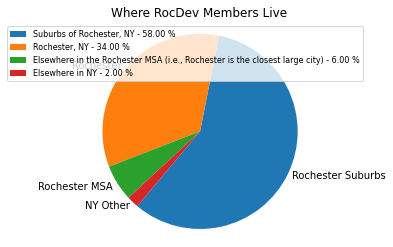

<Figure size 1200x1200 with 0 Axes>

In [5]:
mmpie(data, "domicile", "Where RocDev Members Live", 230, "upper right", ["Rochester Suburbs", "Rochester", "Rochester MSA", "NY Other"])

What kind of jobs to RocDev members do?  Is everyone a software developer primarily?
How many people do DevOps?  How many people are in related roles, like testing, IT,
and management?

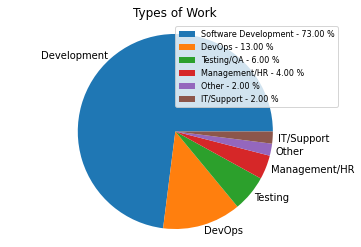

<Figure size 1200x1200 with 0 Axes>

In [6]:
mmpie(data, "job_role", "Types of Work", 0, "upper right", ["Development", "DevOps", "Testing", "Management/HR", "Other", "IT/Support"])

Most RocDev members have a bachelors' degree, though a sizable fraction have masters'
degrees as well.

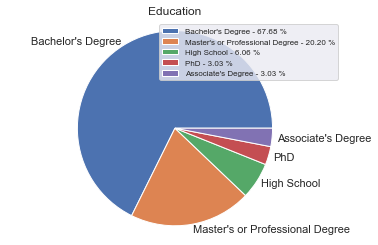

<Figure size 1200x1200 with 0 Axes>

In [70]:
mmpie(data, "education", "Education", 0, "upper right", [])

The average RocDev participant has around 13 years of experience in the industry.
There's also a "long tail" of people with considerably more experience.

In [8]:
data['tech_tenure'].mean()


13.23

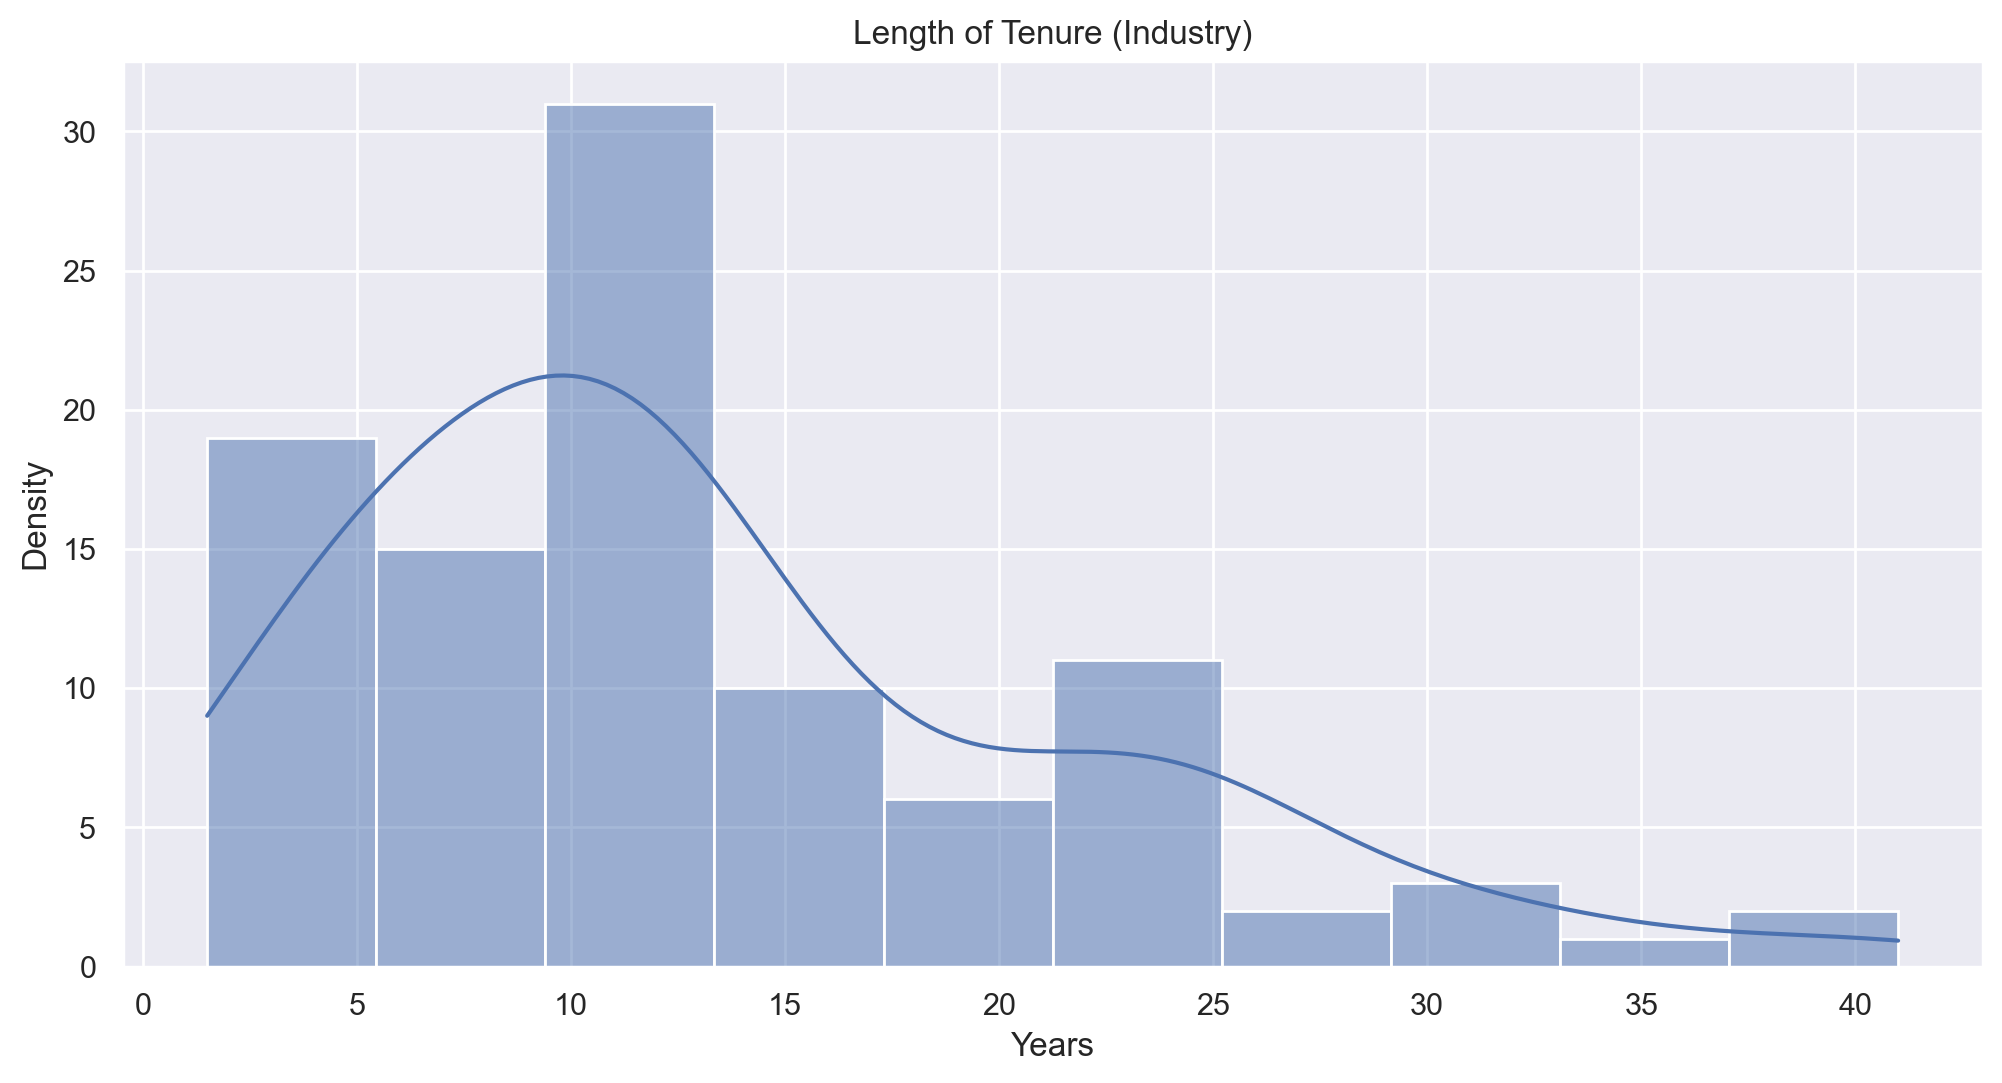

In [9]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(data, x="tech_tenure", kde=True)
plot.set(
    xlabel="Years",
    ylabel="Density",
    title="Length of Tenure (Industry)"
)
plot.get_figure().savefig("figures/tech_tenure.svg")
plt.show()
plt.close('all')

Participants in RocDev are predominately white and male.  This is broadly consistent
with the broader demographic trends in software development overall, given the
demographic composition of the greater Rochester area itself and the inherent
uncertainty with small sample sizes.


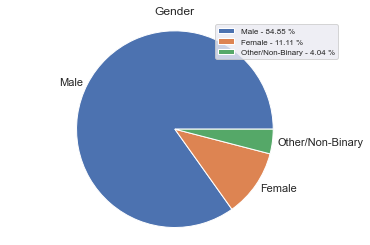

<Figure size 1200x1200 with 0 Axes>

In [10]:
mmpie(data, "gender", "Gender", 0, "upper right", [])

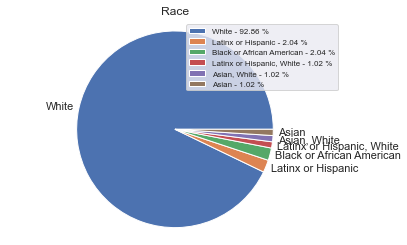

<Figure size 1200x1200 with 0 Axes>

In [11]:
mmpie(data, "race", "Race", 0, "upper right", [])

Other demographic variables of interest were the proportion of RocDev
participants who are parents (or expecting) or self-identify as a person
with some mental or physical disability, an LGBT person, or non-citizens.

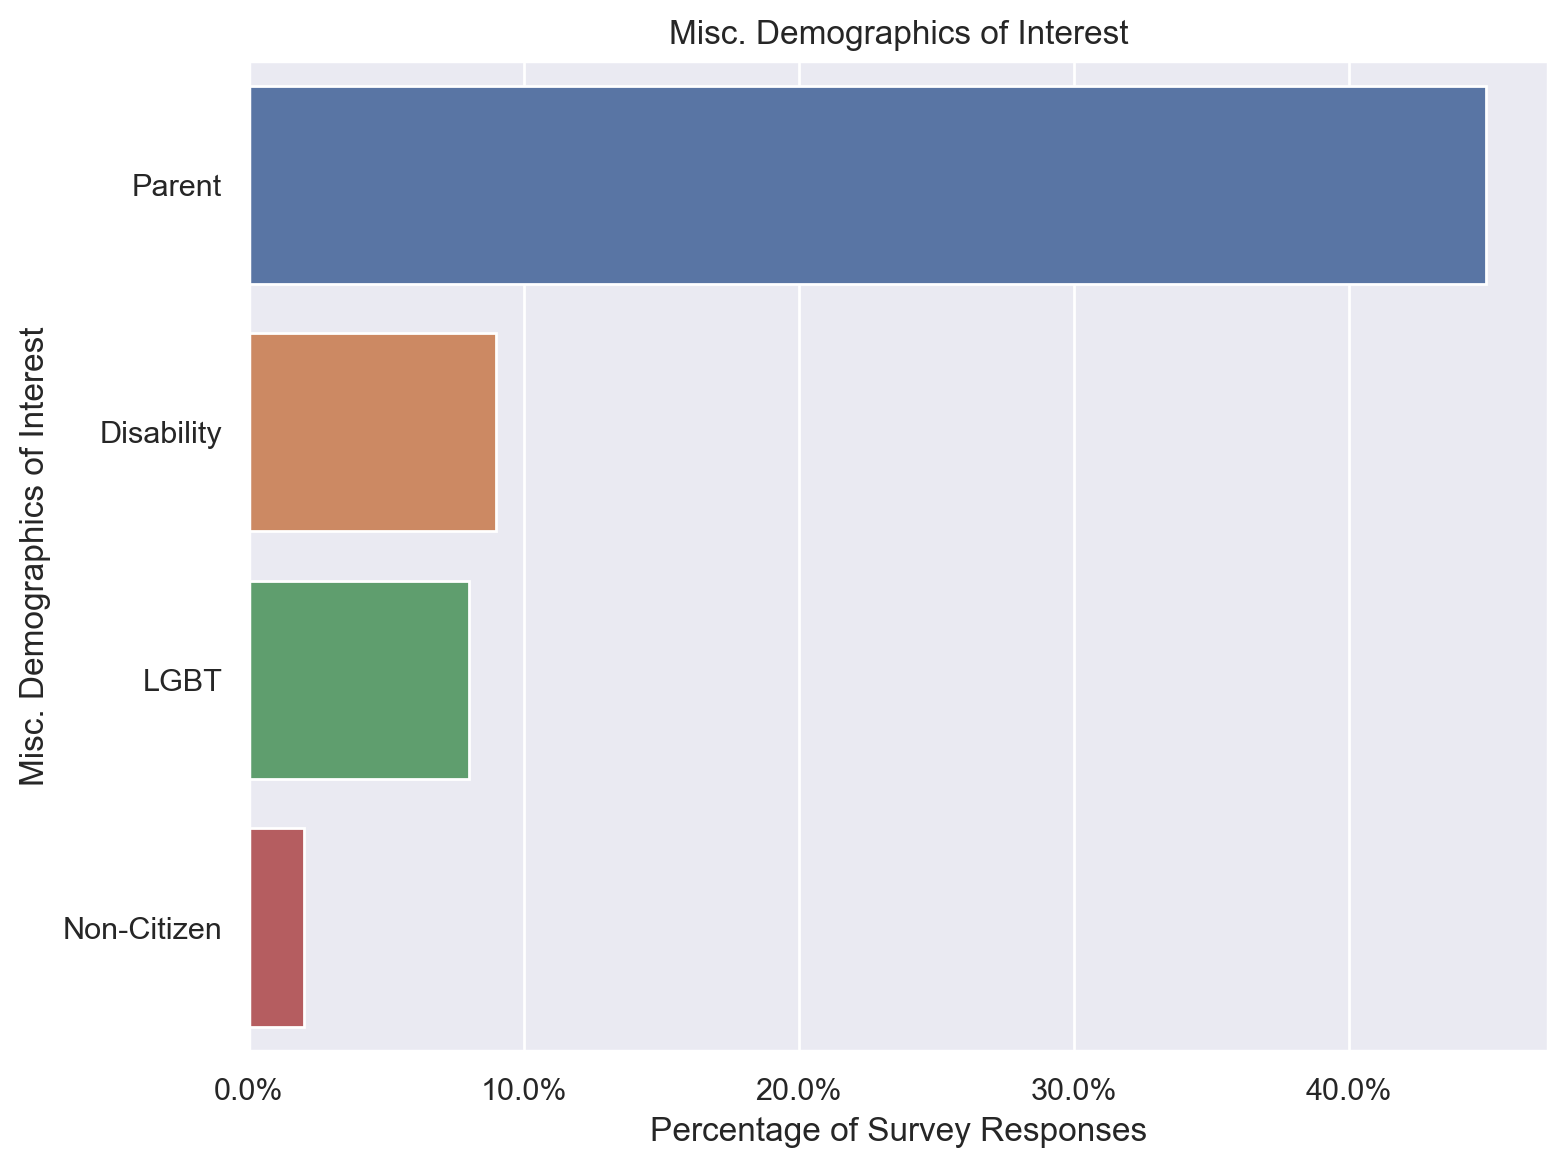

In [12]:
misc_labels = [
    "Parent",
    "Disability",
    "LGBT",
    "Non-Citizen",
]
misc_percentages = [
    data['misc_parent'].mean() * 100,
    data['misc_disability'].mean() * 100,
    data['misc_lgbt'].mean() * 100,
    data['misc_foreigner'].mean() * 100,
]
misc_df = pd.DataFrame({'Misc': misc_labels, 'Percentage':misc_percentages })

plt.figure(figsize=(8,6), dpi=200)
plot = sns.barplot(y="Misc", x="Percentage", data=misc_df)
plot.xaxis.set_major_formatter(mtick.PercentFormatter())
plot.set(
    xlabel="Percentage of Survey Responses",
    ylabel="Misc. Demographics of Interest",
    title="Misc. Demographics of Interest"
)
plt.tight_layout()
plot.get_figure().savefig("figures/misc.svg")
plt.show()
plt.close()


# About Employers and Jobs
Employers are roughly split between those that are primarily located in Rochester
and those that are primarily located elsewhere.  This is likely to have some overlap
with the portion of people do primarily do remote / telecommuting work.

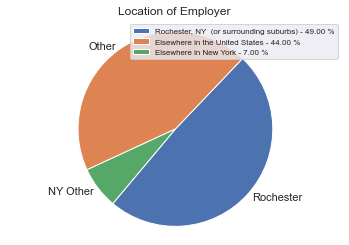

<Figure size 1200x1200 with 0 Axes>

In [13]:
mmpie(data, "org_where", "Location of Employer", 230, "upper right", ['Rochester', 'Other', 'NY Other'])

The size of companies that RocDev participants work for varies considerably.  Note that
the plot below uses a logarithmic scale, and has a bimodal distribution with the first
mode around 50 employees and the second around 13,000 employees.

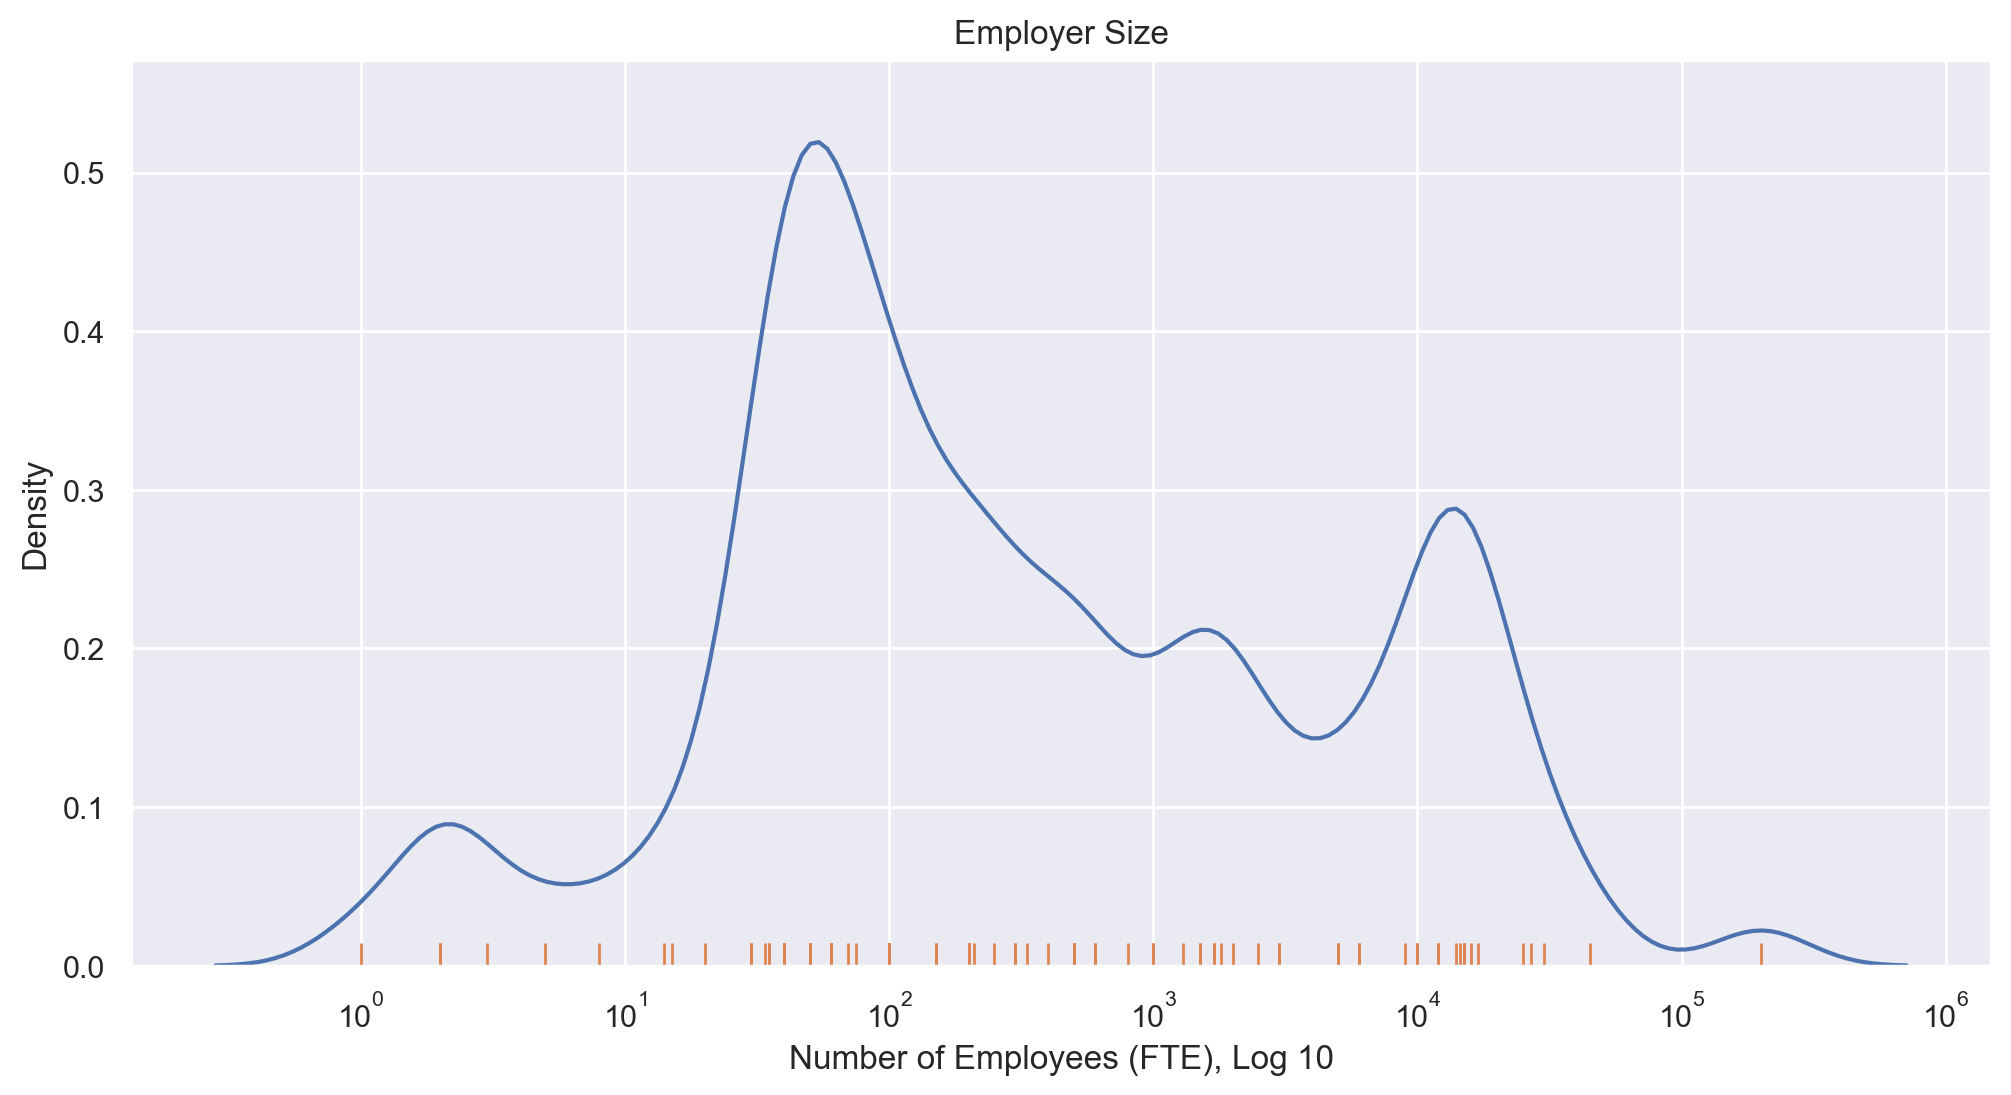

In [58]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.kdeplot(data['org_size'].dropna(), log_scale=True, bw_adjust=0.4)
sns.rugplot(data=data, x="org_size")
plot.set(
    xlabel="Number of Employees (FTE), Log 10",
    ylabel="Density",
    title="Employer Size"
)
plot.get_figure().savefig("figures/org_size.svg")
plt.show()
plt.close('all')

Unsurprisingly, the vast majority of respondents work in the private sector.  The
ratio of people working for small, privately-held companies to publicly traded
companies was a little more than 2:1.

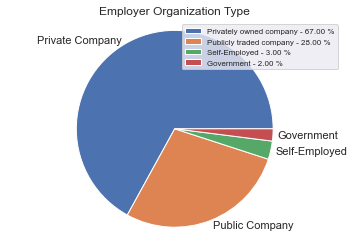

<Figure size 1200x1200 with 0 Axes>

In [15]:
mmpie(data, "org_type", "Employer Organization Type", 0, 'upper right', ['Private Company', 'Public Company', 'Self-Employed', 'Government'])

Surprisingly, a full 43% of respondents indicated that they work primarily
remotely (i.e., telecommute)--even before COVID-19 pandemic--while another
24% do so occasionally.  Assuming these results are correct, the number of
of remote workers increased significantly, over the past year, from 34.2% 
in 2019 to 43% in 2020.

While this change represents a dramatic 25.7% increase in remote
work from year-to-year, there are reasons to view this estimate with
caution.  First, while the question prompt asked about remote work
pre-COVID, it is possible that a few people mis-read the question and
provided their remote status _post_ COVID.  Second, recall that
convenience samples contain various types of bias, and this may be inflating
the number of remote workers participating this year.  For example, remote
workers with even fewer other opportunities for social connection during
the pandemic may have been more likely to participate in RocDev forums this
year.  Finally, given the small sample size we'd naturally expect some
variation in the estimate from year-to-year, even if the underlying rate
was unchanged.

Nevertheless, the question of whether the shift to remote work will
persist after the pandemic will be of considerable interest to our
community over the coming year(s).

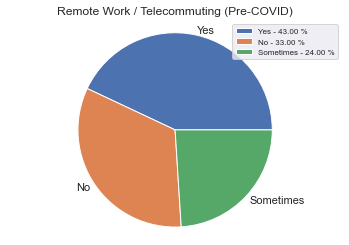

<Figure size 1200x1200 with 0 Axes>

In [16]:
mmpie(data, "job_remote", "Remote Work / Telecommuting (Pre-COVID)", 0, "upper right", [])

The large majority of respondents were employed directly, rather than through
contracting agencies.

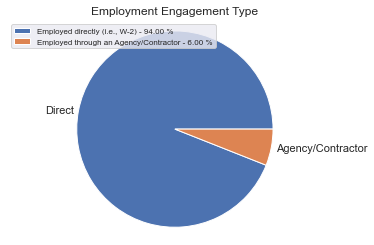

<Figure size 1200x1200 with 0 Axes>

In [17]:
mmpie(data, "job_type", "Employment Engagement Type", 0, 'upper left', ["Direct", "Agency/Contractor"])

10% of respondents have forma, recall that a few of these are
likely to be some of the respondents who are primarily managers, so not all
of these people are developers supervising other developers.

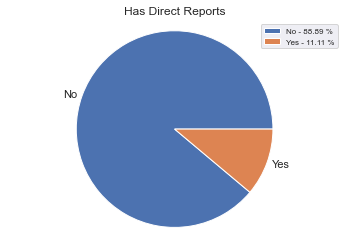

<Figure size 1200x1200 with 0 Axes>

In [18]:
mmpie(data, "job_supervisor", "Has Direct Reports", 0, "upper right", [])

A considerable portion (23%) also had some kind of second job or were
involved in side projects, in addition to their primary employment.

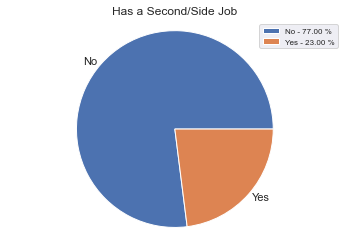

<Figure size 1200x1200 with 0 Axes>

In [19]:
mmpie(data, "side_job", "Has a Second/Side Job", 0, "upper right", [])

Another interesting aspect of the technology industry is the relatively short
length of time that people will stay in the same job before moving on.
Across _all_ respondents, the average amount of time in a job was around 3.4
years.  However, it's also important to note that the distribution has some
right skew, so the more typical length of time people stay in the same job
is closer to 2.5 years.

In [20]:
data['job_avg_tenure'].mean()

3.361843837535014

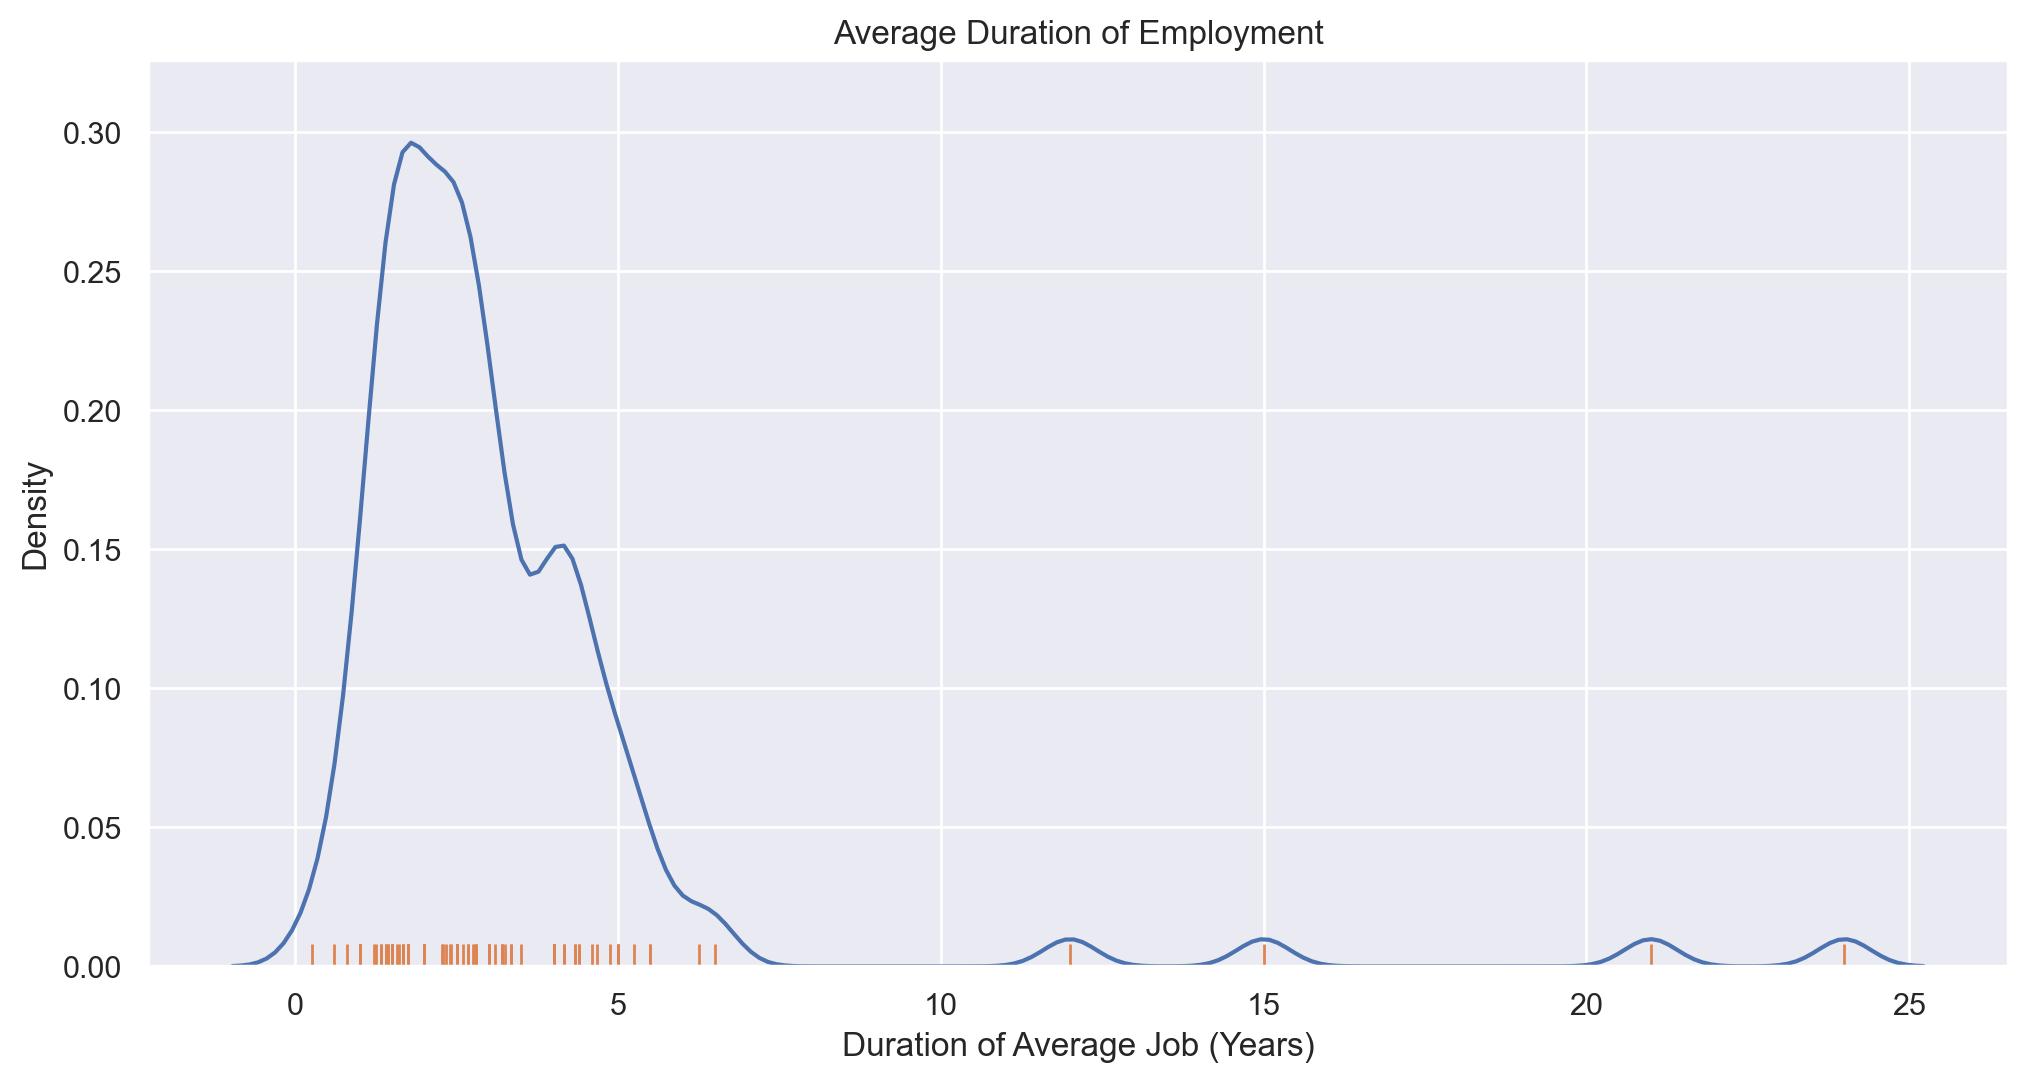

In [21]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.kdeplot(data['job_avg_tenure'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="job_avg_tenure")
plot.set(
    xlabel="Duration of Average Job (Years)",
    ylabel="Density",
    title="Average Duration of Employment"
)
plot.get_figure().savefig("job_avg_tenure.svg")
plt.show()
plt.close('all')

The substantial majority of respondents reported working standard 40-hour weeks, while the remainder skewed towards slightly longer weeks.

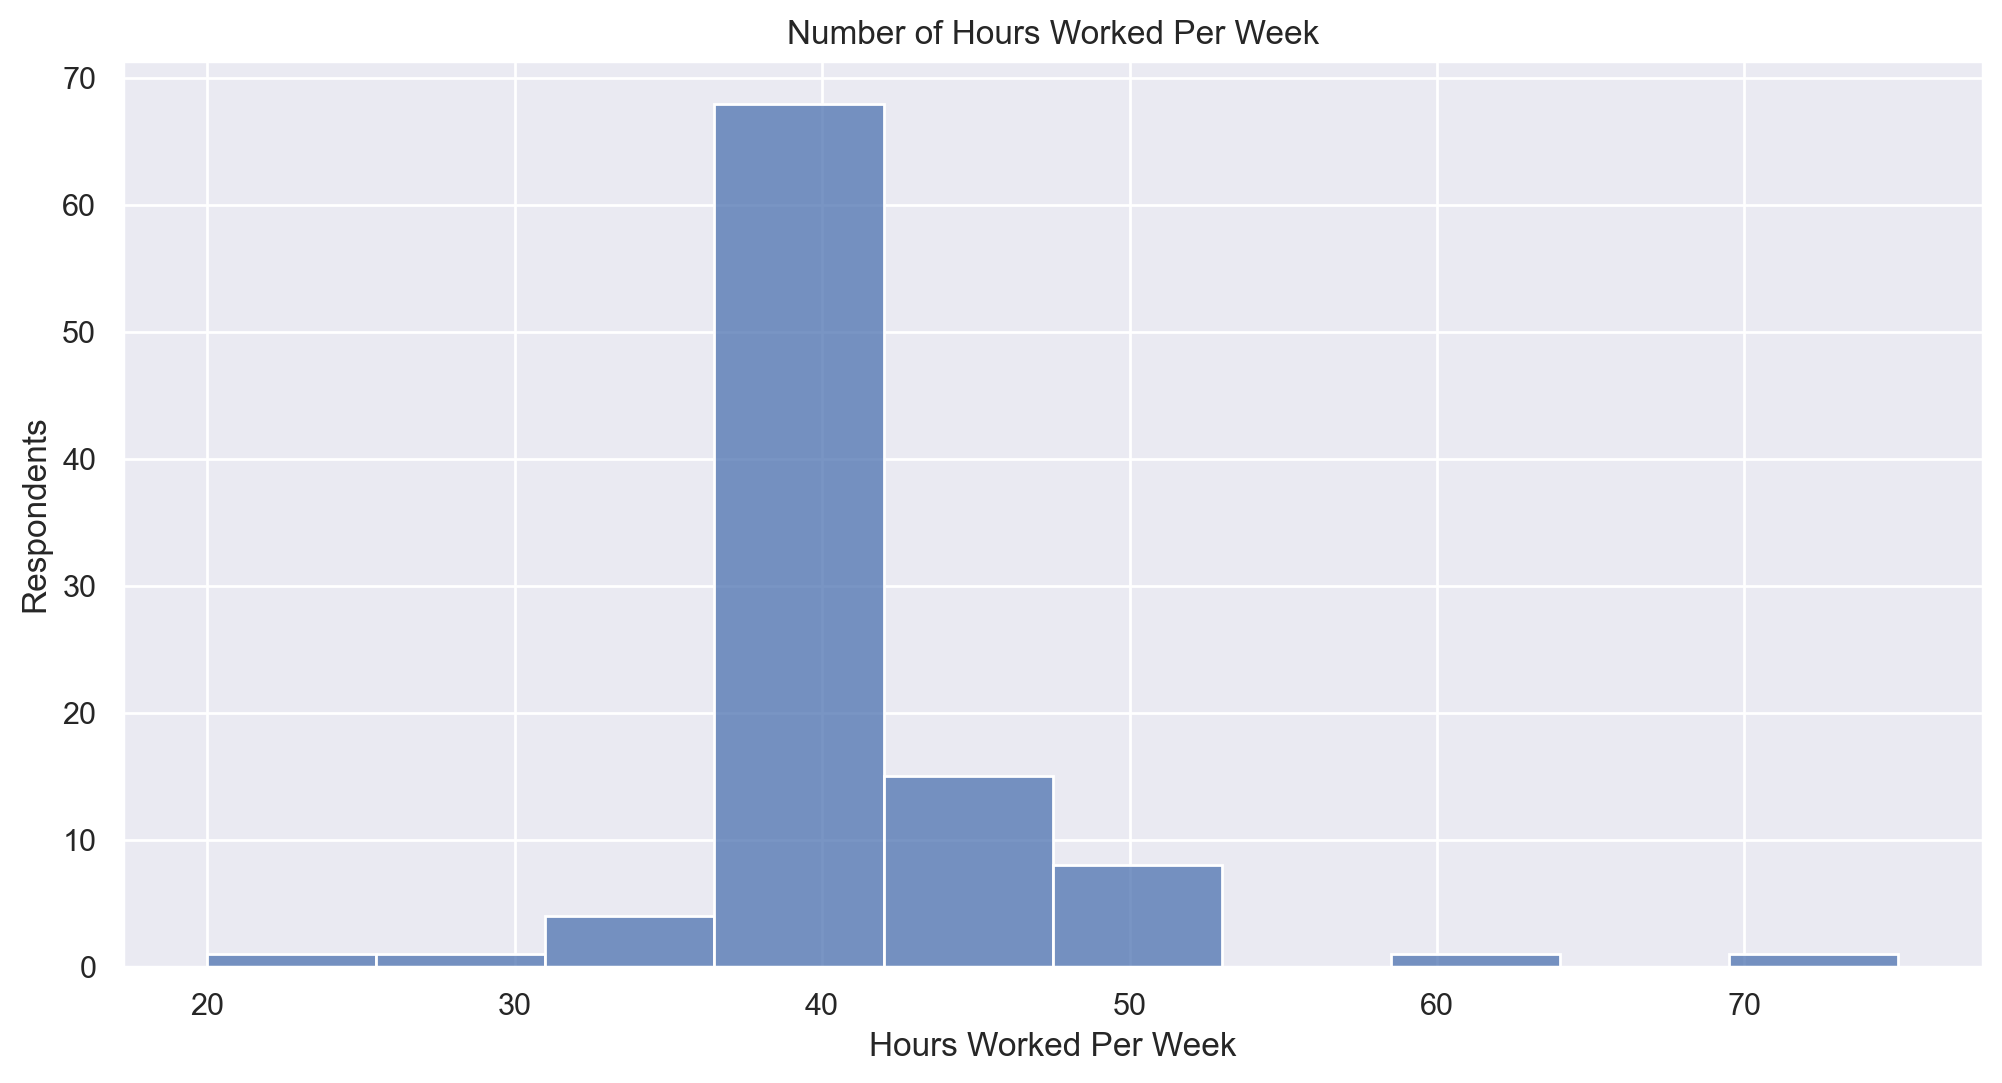

In [60]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "job_hours", bins=10, data=data)
plot.set(
    xlabel="Hours Worked Per Week",
    ylabel="Respondents",
    title="Number of Hours Worked Per Week"
)
plot.get_figure().savefig("figures/job_hours.svg")
plt.show()
plt.close('all')


# Compensation

The average yearly salary for RocDev members was 122,000, though this varied
considerably both across individuals (the standard deviation was 44,000) and
several categorical variables (as described below).

In [23]:
data['job_pay'].describe()

count    100.000000
mean     120.795000
std       44.817931
min       50.000000
25%       88.000000
50%      115.000000
75%      140.000000
max      280.000000
Name: job_pay, dtype: float64

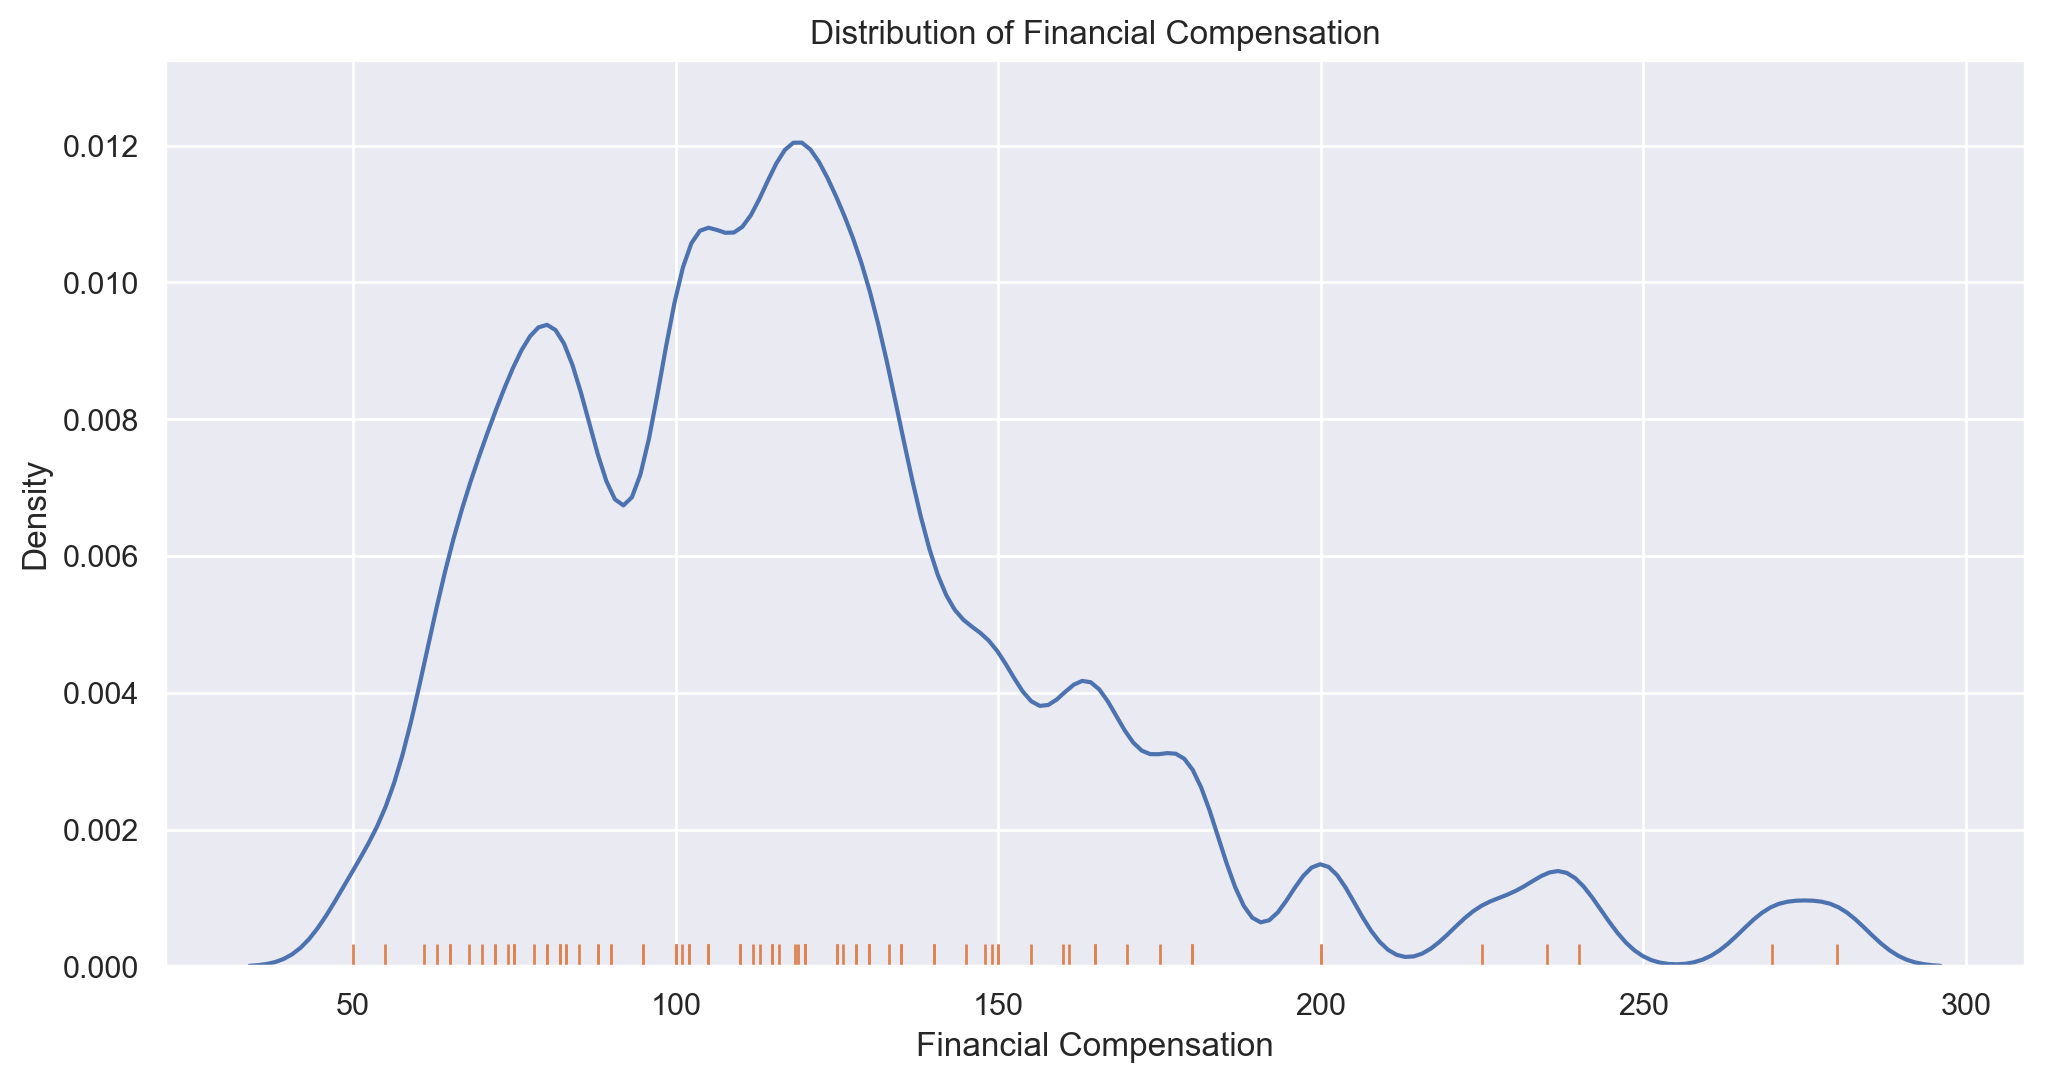

In [24]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.kdeplot(data['job_pay'].dropna(), bw_adjust=0.3)
sns.rugplot(data=data, x="job_pay")
plot.set(
    xlabel="Financial Compensation",
    ylabel="Density",
    title="Distribution of Financial Compensation"
)
plot.get_figure().savefig("job_pay.svg")
plt.show()
plt.close('all')

Average income varied based on an individual's level of experience in the
technology industry, with salaries increasing by an average of around
$2,600 for each additional year of experience.

In [25]:
model = sm.ols(formula="job_pay ~ tech_tenure", data=data)
result = model.fit();
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     31.55
Date:                Fri, 20 Nov 2020   Prob (F-statistic):           1.82e-07
Time:                        23:12:57   Log-Likelihood:                -507.70
No. Observations:                 100   AIC:                             1019.
Df Residuals:                      98   BIC:                             1025.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      86.7645      7.215     12.026      

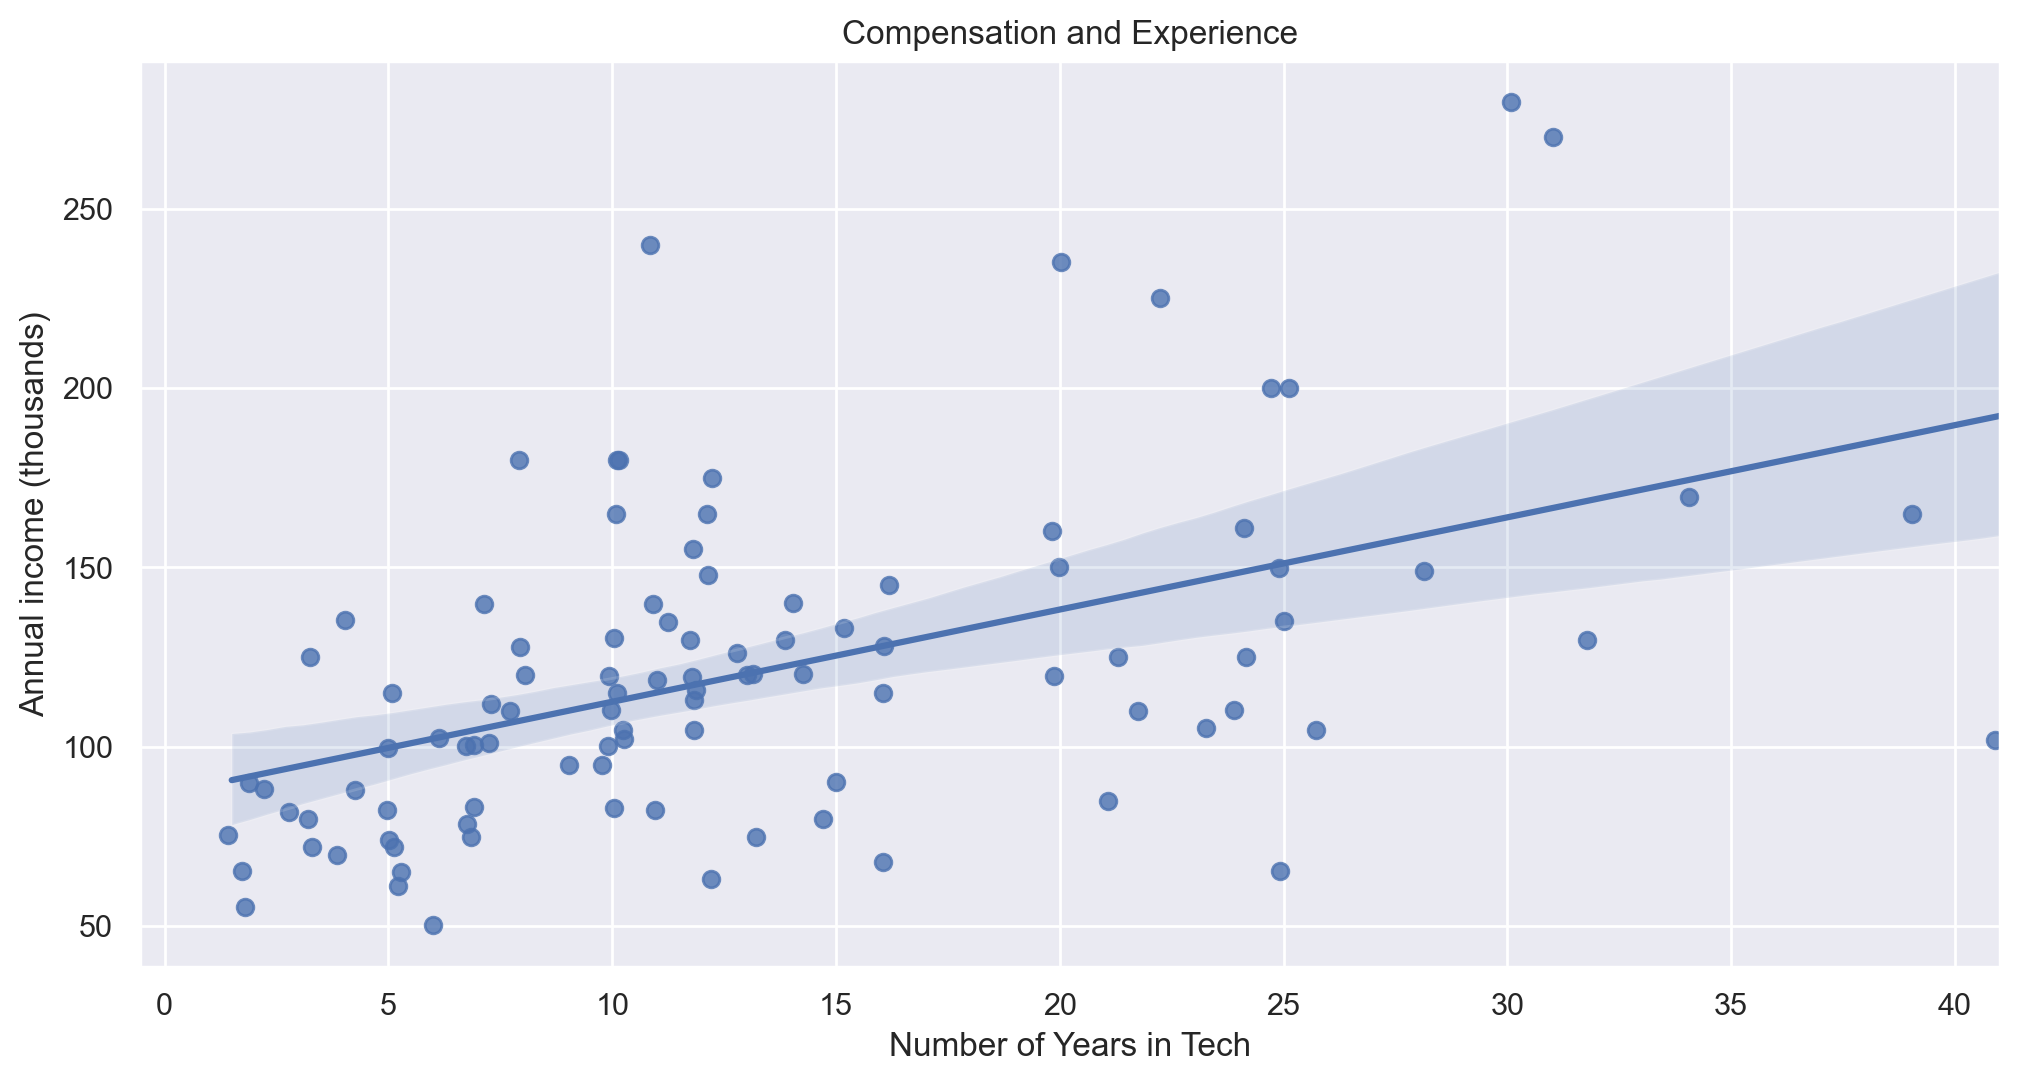

In [26]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.regplot(
    x = "tech_tenure",
    y = "job_pay",
    x_jitter = 0.3,
    y_jitter = 0.3,
    data=data)
plot.set(
    xlabel="Number of Years in Tech",
    ylabel="Annual income (thousands)",
    title="Compensation and Experience"
)
plot.get_figure().savefig("figures/job_pay_vs_tech_tenure.svg")
plt.show()
plt.close('all')

While visualization of the data shows some apparent differences in the typical
salary across different education levels, the small number of respondents in
most categories and the large variation in salaries overall prevent making
reliable statistical inferences about these differences.

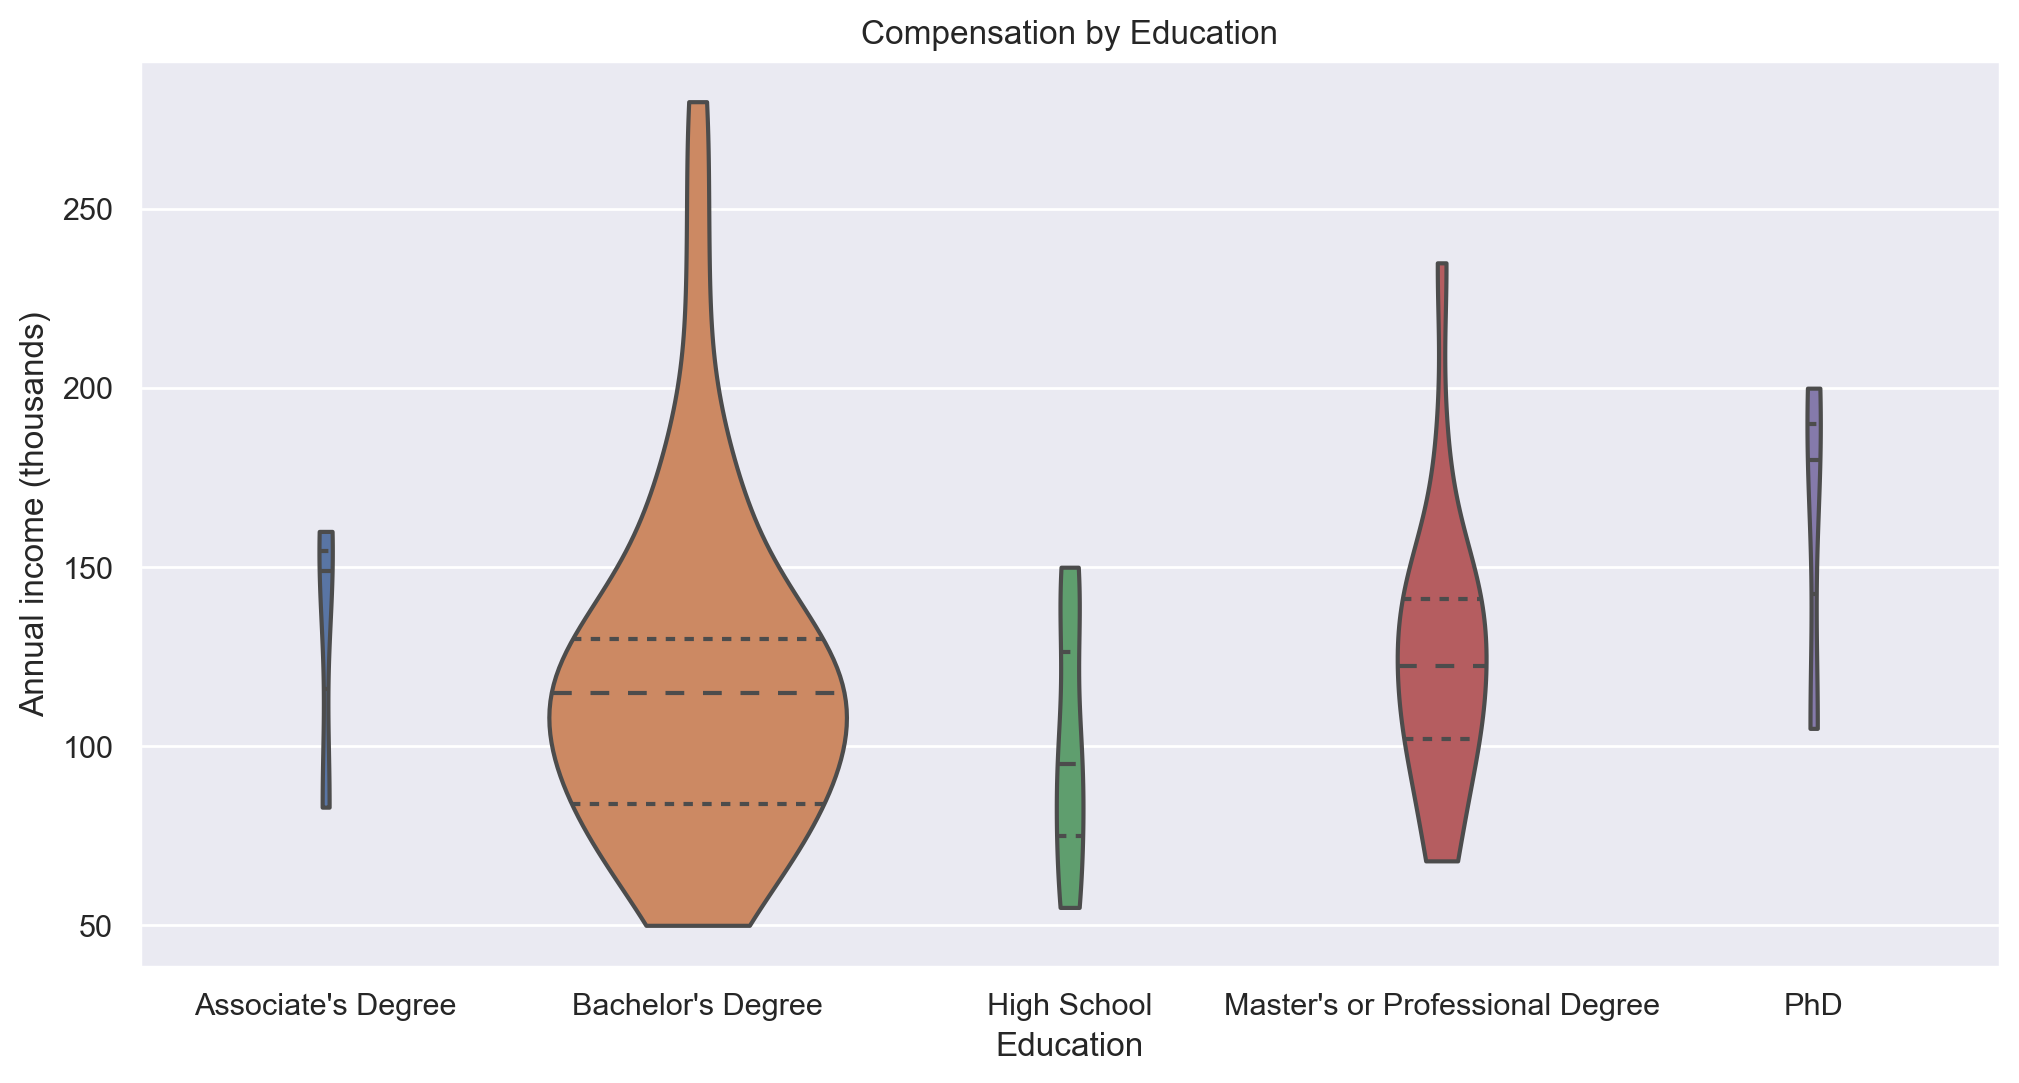

In [27]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "education",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Education",
    ylabel="Annual income (thousands)",
    title="Compensation by Education"
)
plot.get_figure().savefig("figures/job_pay_vs_education.svg")
plt.show()


The same is true for comparisons between different types of work.

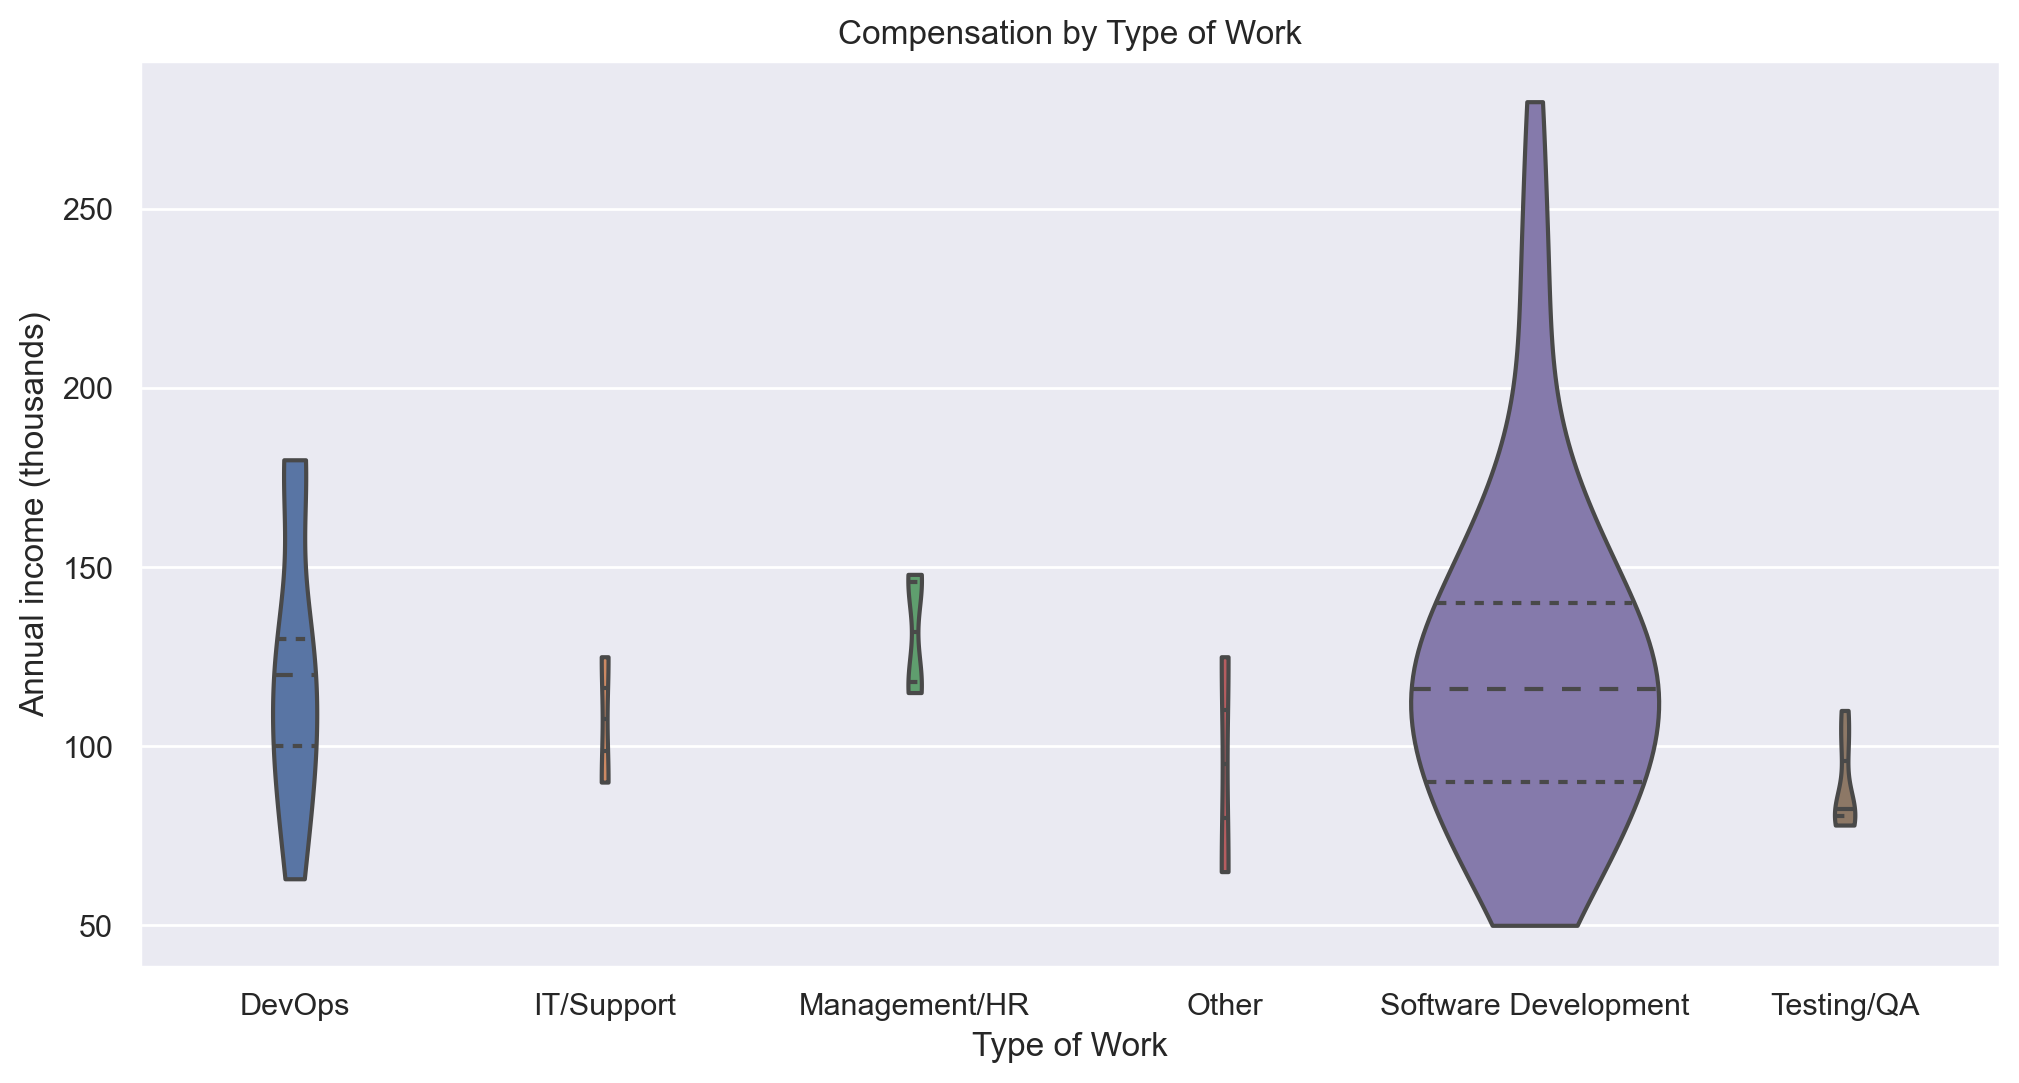

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8921
Date:                Sun, 22 Nov 2020   Prob (F-statistic):              0.490
Time:                        14:12:59   Log-Likelihood:                -519.33
No. Observations:                 100   AIC:                             1051.
Df Residuals:                      94   BIC:                             1066.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [53]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "job_role",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Type of Work",
    ylabel="Annual income (thousands)",
    title="Compensation by Type of Work"
)
plot.get_figure().savefig("figures/job_pay_vs_job_role.svg")
plt.show()


model = sm.ols(formula="job_pay ~ job_role", data=data)
result = model.fit();
print(result.summary())

However, we can say with some confidence that, on average, remote work
pays more.  The average salary for local jobs was around 102,000, while
the average salary for those working remotely was around 143,000.

If the shift to more remote work persists long-term, this may put upward pressure
on the salaries necessary for local employers to attract and retain technical staff.

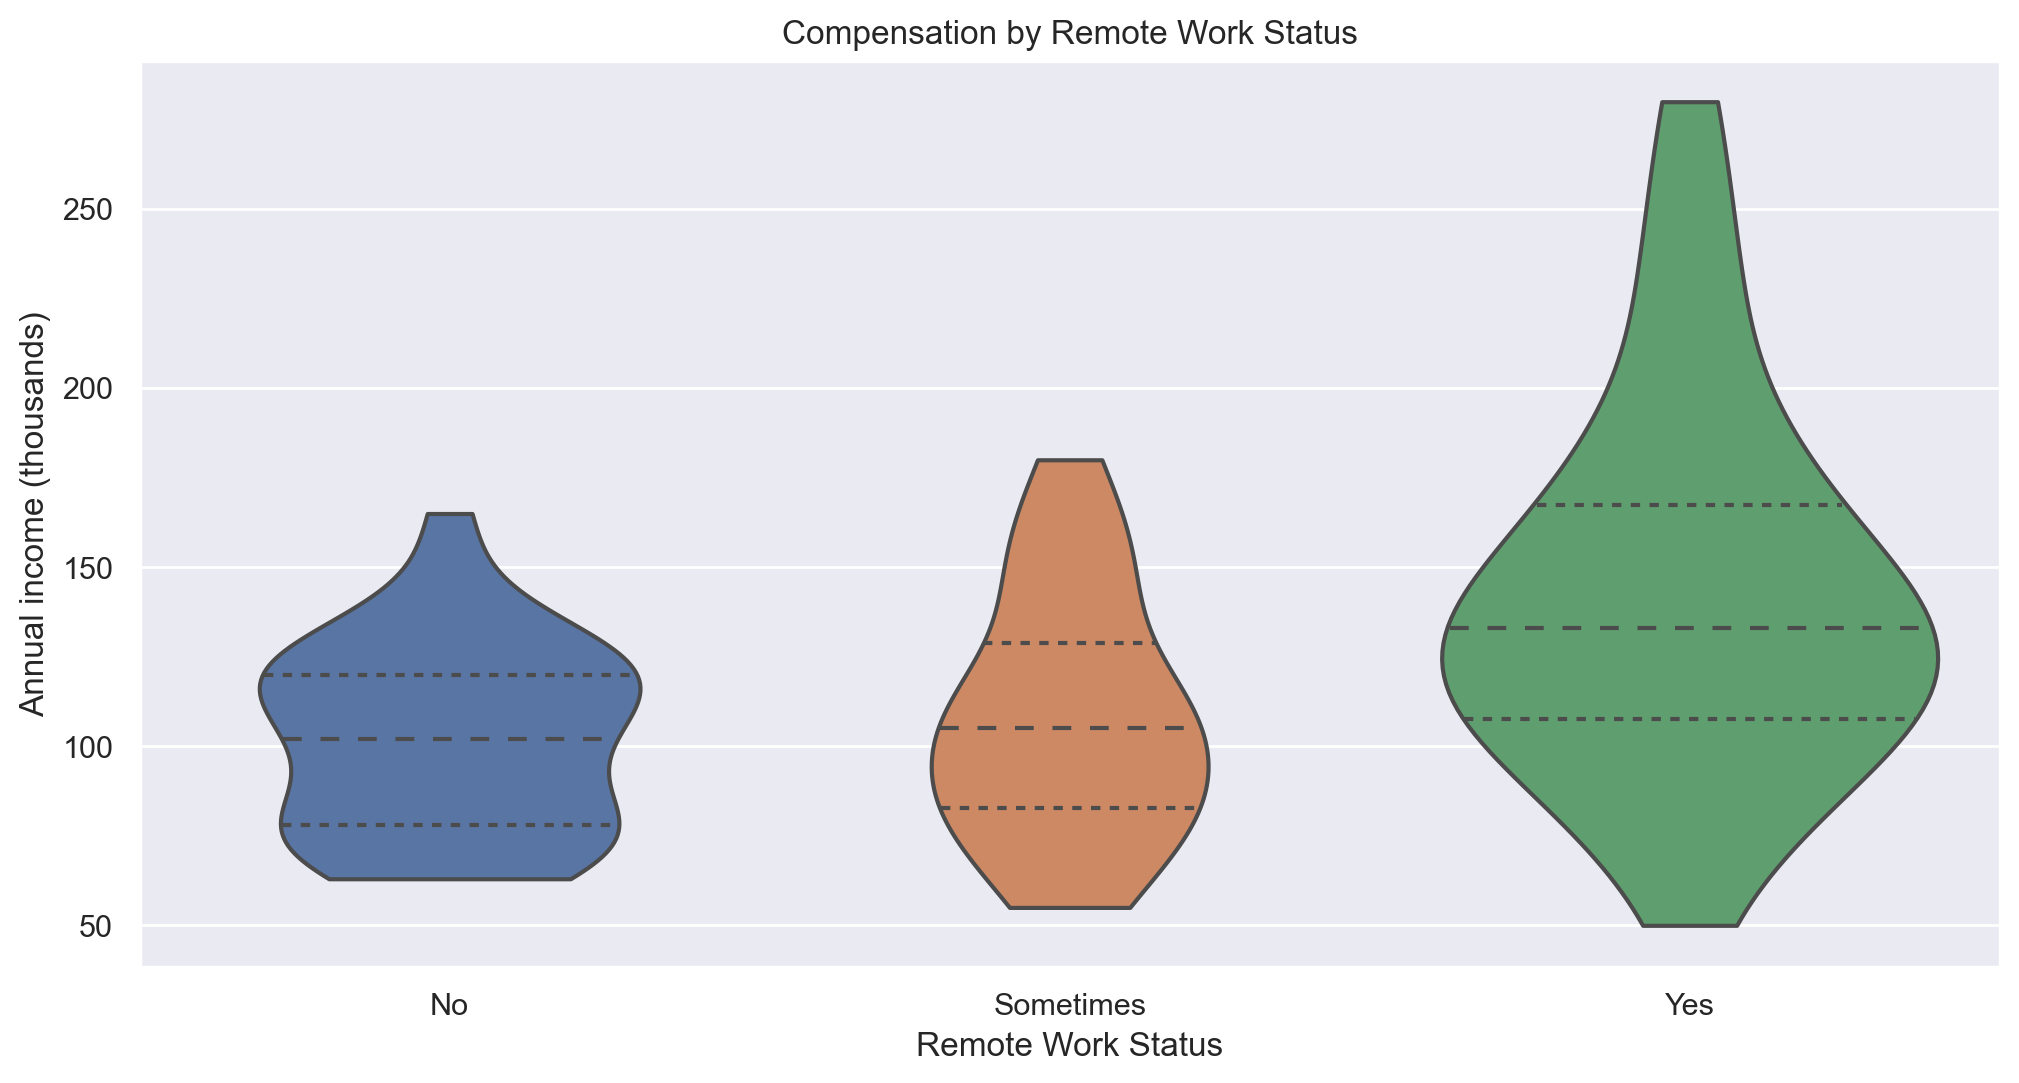

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     10.90
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           5.36e-05
Time:                        14:12:29   Log-Likelihood:                -511.51
No. Observations:                 100   AIC:                             1029.
Df Residuals:                      97   BIC:                             1037.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [52]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "job_remote",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Remote Work Status",
    ylabel="Annual income (thousands)",
    title="Compensation by Remote Work Status"
)
plot.get_figure().savefig("figures/job_pay_vs_job_remote.svg")
plt.show()

model = sm.ols(formula="job_pay ~ job_remote", data=data)
result = model.fit();
print(result.summary())

Of the

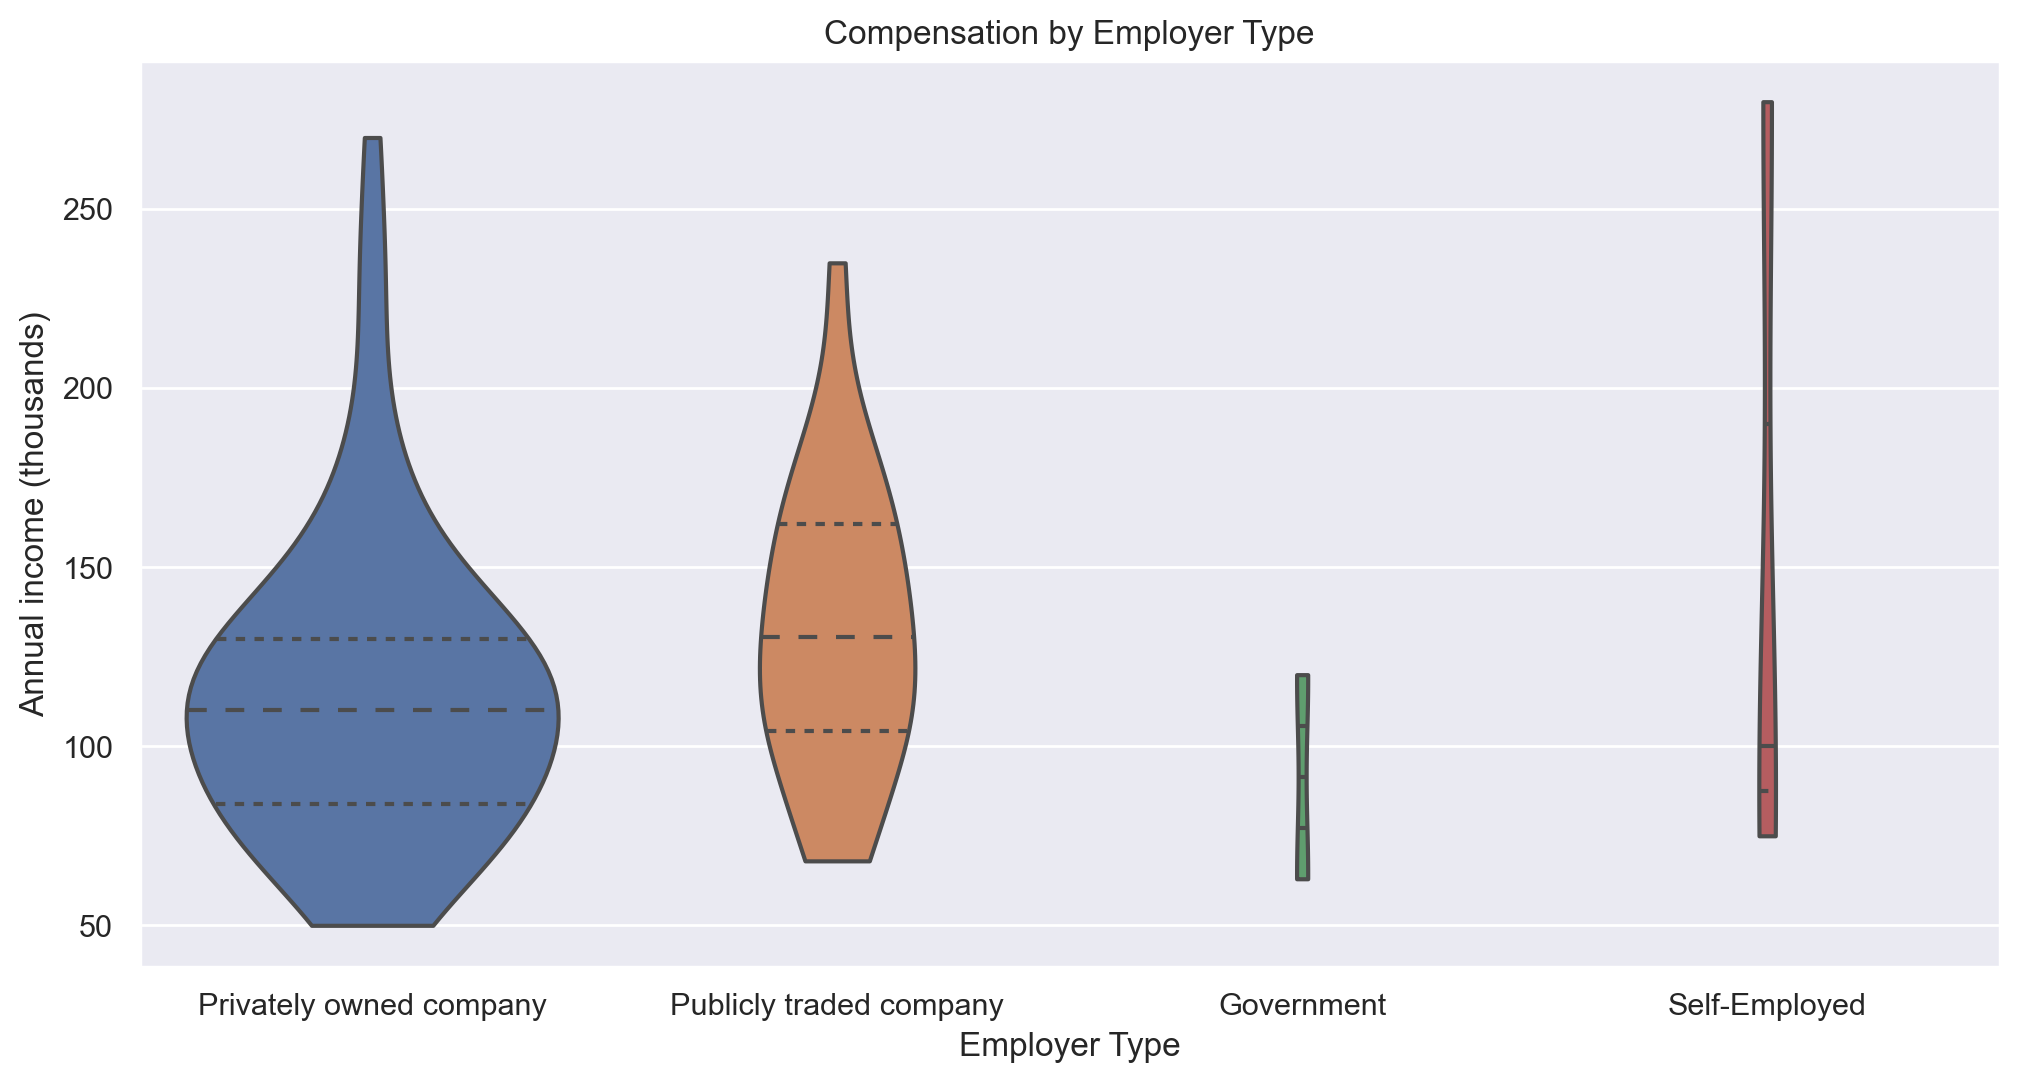

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.741
Date:                Sun, 22 Nov 2020   Prob (F-statistic):              0.164
Time:                        14:14:04   Log-Likelihood:                -519.00
No. Observations:                 100   AIC:                             1046.
Df Residuals:                      96   BIC:                             1056.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [54]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "org_type",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Employer Type",
    ylabel="Annual income (thousands)",
    title="Compensation by Employer Type"
)
plot.get_figure().savefig("figures/job_pay_vs_org_type.svg")
plt.show()

model = sm.ols(formula="job_pay ~ org_type", data=data)
result = model.fit();
print(result.summary())

While larger employers did pay more on average, the difference was small enough as to be not statistically significant.

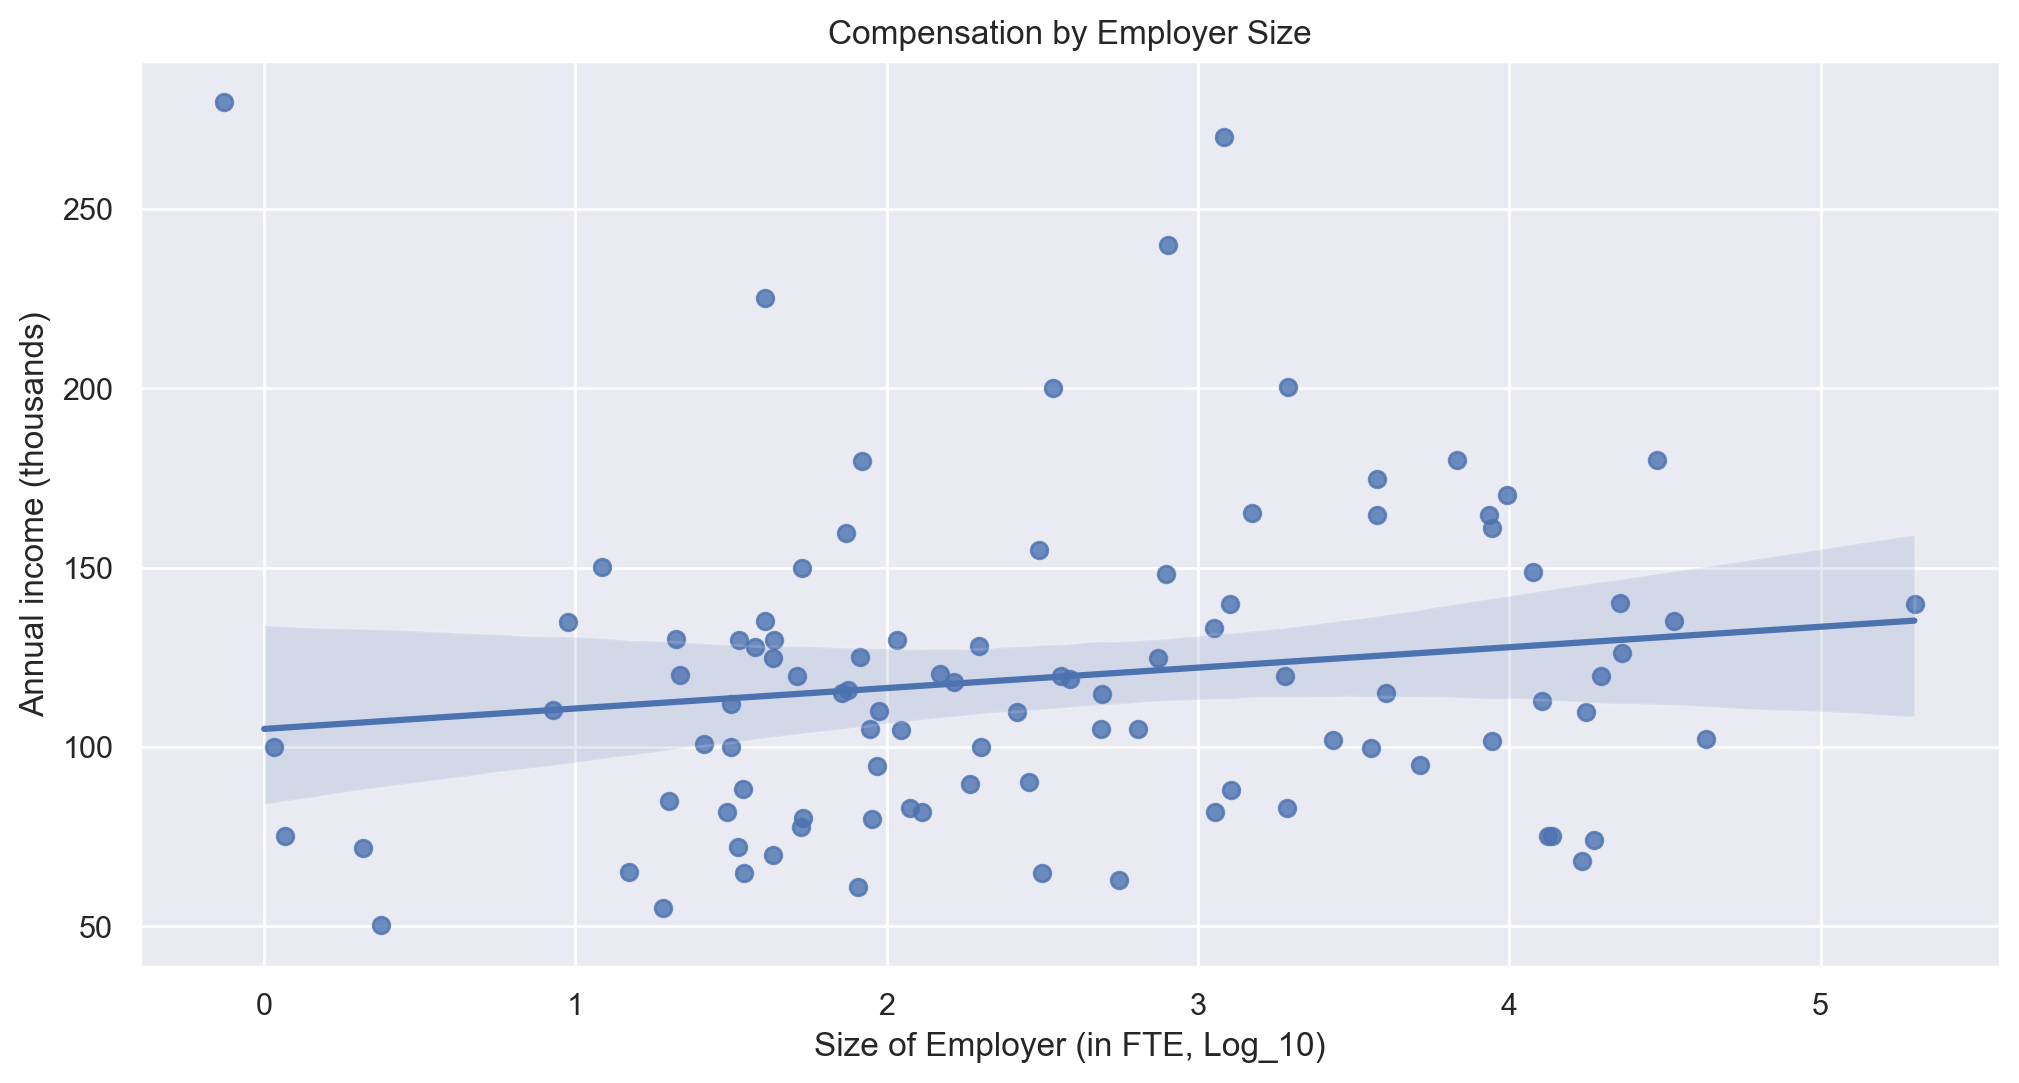

In [46]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.regplot(
    x = "log_org_size",
    y = "job_pay",
    x_jitter = 0.3,
    y_jitter = 0.3,
    data=data,
                   )
plot.set(
    xlabel="Size of Employer (in FTE, Log_10)",
    ylabel="Annual income (thousands)",
    title="Compensation by Employer Size"
)
plot.get_figure().savefig("figures/job_pay_vs_org_size.svg")
plt.show()
plt.close('all')

The most common amount of paid vacation was four weeks per year, though
this represented a only a little less than half of respondents.

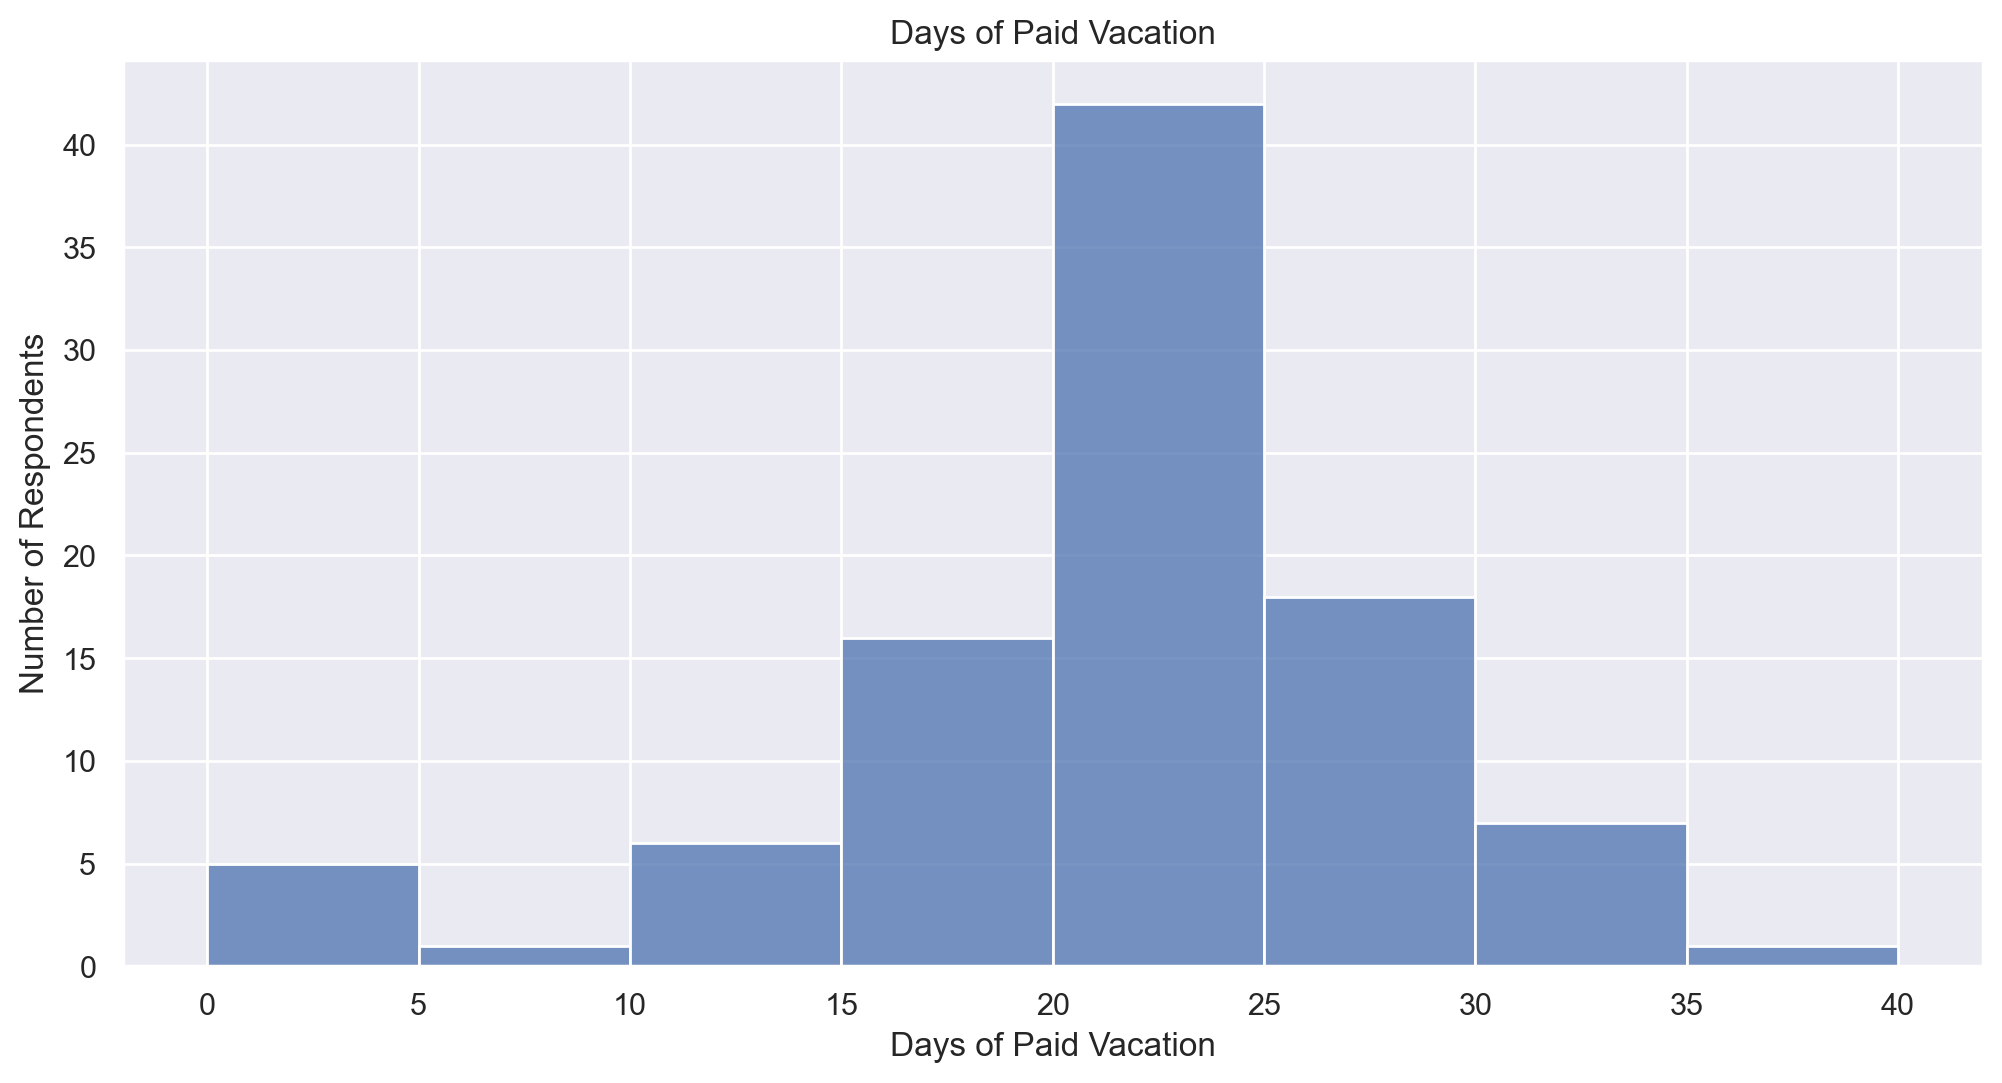

In [34]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(x = "job_vacation", bins=8, data=data)
plot.set(
    xlabel="Days of Paid Vacation",
    ylabel="Number of Respondents",
    title="Days of Paid Vacation"
)
plot.get_figure().savefig("figures/job_vacation.svg")
plt.show()

The most common benefits provided were health, dental, and vision insurance,
followed by matching contributions to eomployee retirement accounts.  Health 
savings accounts were also fairly popular.  Equity (or stock options), profit
sharing / incentive bonuses, and tuition reimbursement were also offered by
some employers.


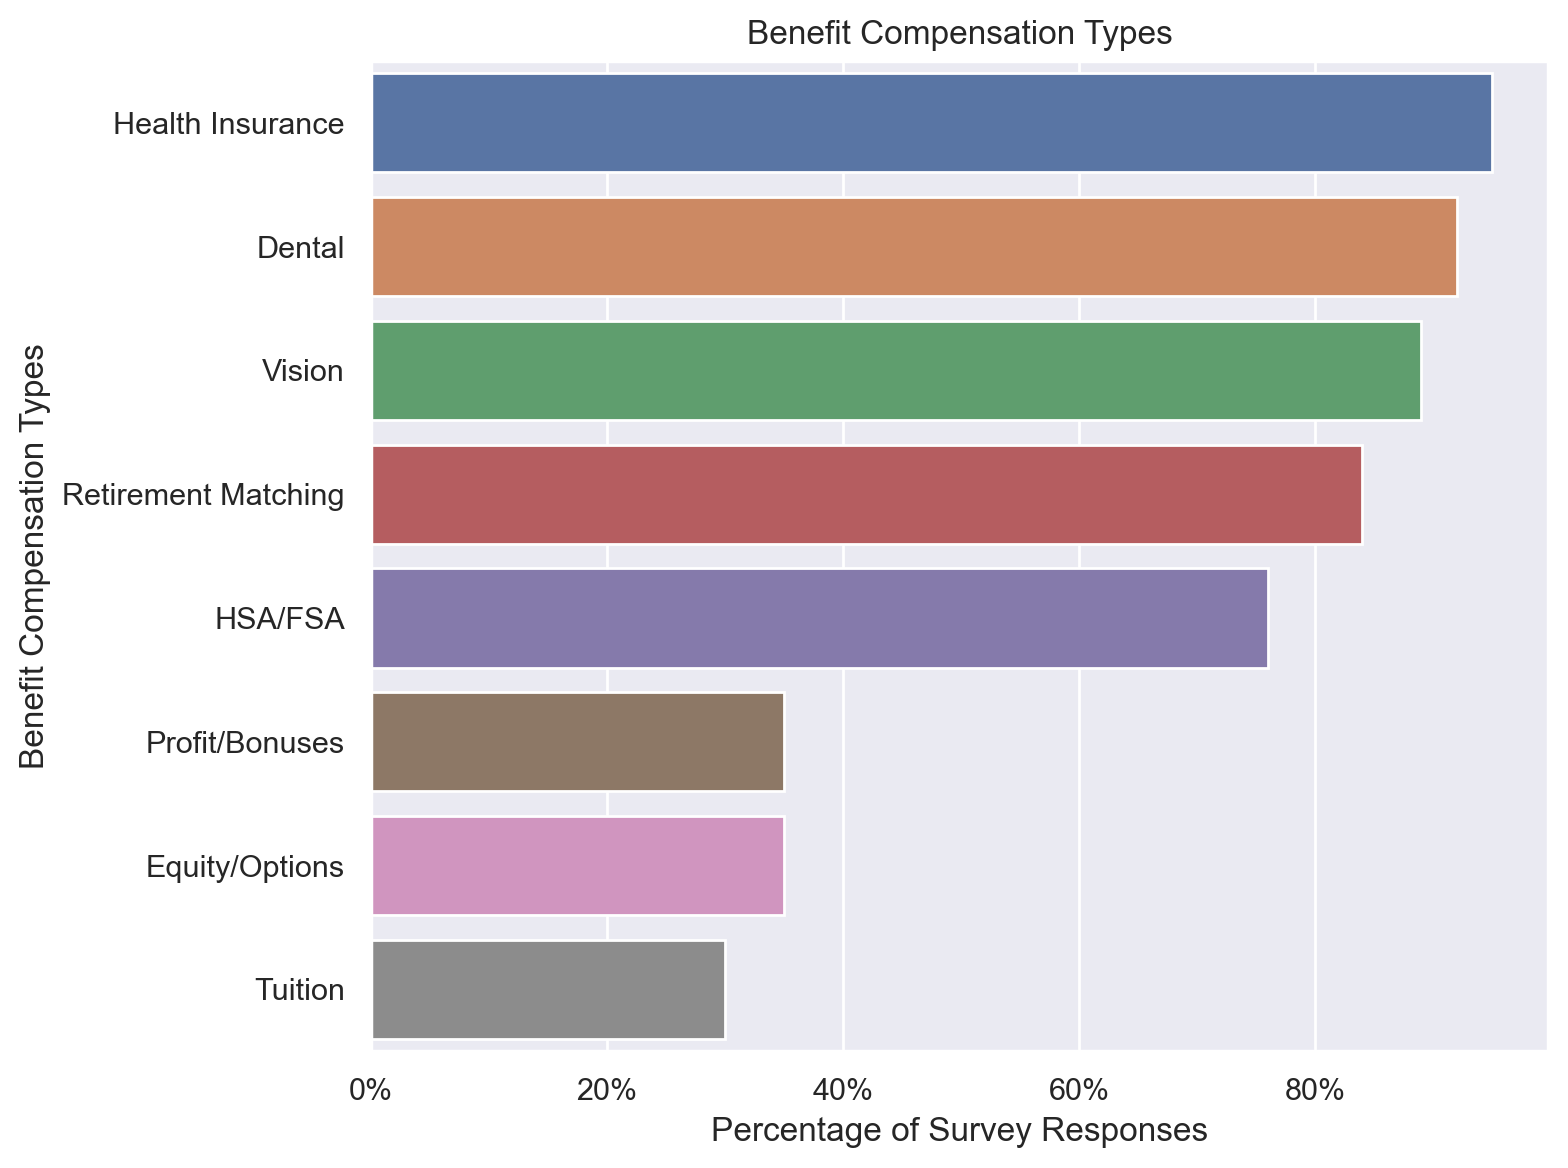

In [35]:
benefit_labels = [
    "Health Insurance",
    "Dental",
    "Vision",
    "Retirement Matching",
    "HSA/FSA",
    "Profit/Bonuses",
    "Equity/Options",
    "Tuition",
]
benefit_percentages = [
    data['benefits_health'].mean() * 100,
    data['benefits_dental'].mean() * 100,
    data['benefits_vision'].mean() * 100,
    data['benefits_retirement_matching'].mean() * 100,
    data['benefits_hsa'].mean() * 100,
    data['benefits_profit_sharing'].mean() * 100,
    data['benefits_equity_options'].mean() * 100,
    data['benefits_tuition'].mean() * 100,
]
benefits_df = pd.DataFrame({'Benefit': benefit_labels, 'Percentage':benefit_percentages })

plt.figure(figsize=(8,6), dpi=200)
plot = sns.barplot(y="Benefit", x="Percentage", data=benefits_df)
plot.xaxis.set_major_formatter(mtick.PercentFormatter())
plot.set(
    xlabel="Percentage of Survey Responses",
    ylabel="Benefit Compensation Types",
    title="Benefit Compensation Types"
)
plt.tight_layout()
plot.get_figure().savefig("figures/benefits.svg")
plt.show()
plt.close('all')


# Covid Responses

Finally, this year we asked a few questions about the COVID-19 pandemic's effect on the industry.  

Unsurpringly, the most common change was the shift to remote work (91%).  The second most common action (38%) was a hiring freeze--a prudent action moving into a period of greatly increased uncertainty in which around a fifth of respondents' employers reduced wages or laid off staff.  A few respondents were laid off themselves and experienced a period of unemployment, though software development wasn't impacted as severely as many other sectors.

In [45]:
data['covid_chaotic'].mean() * 100

2.0

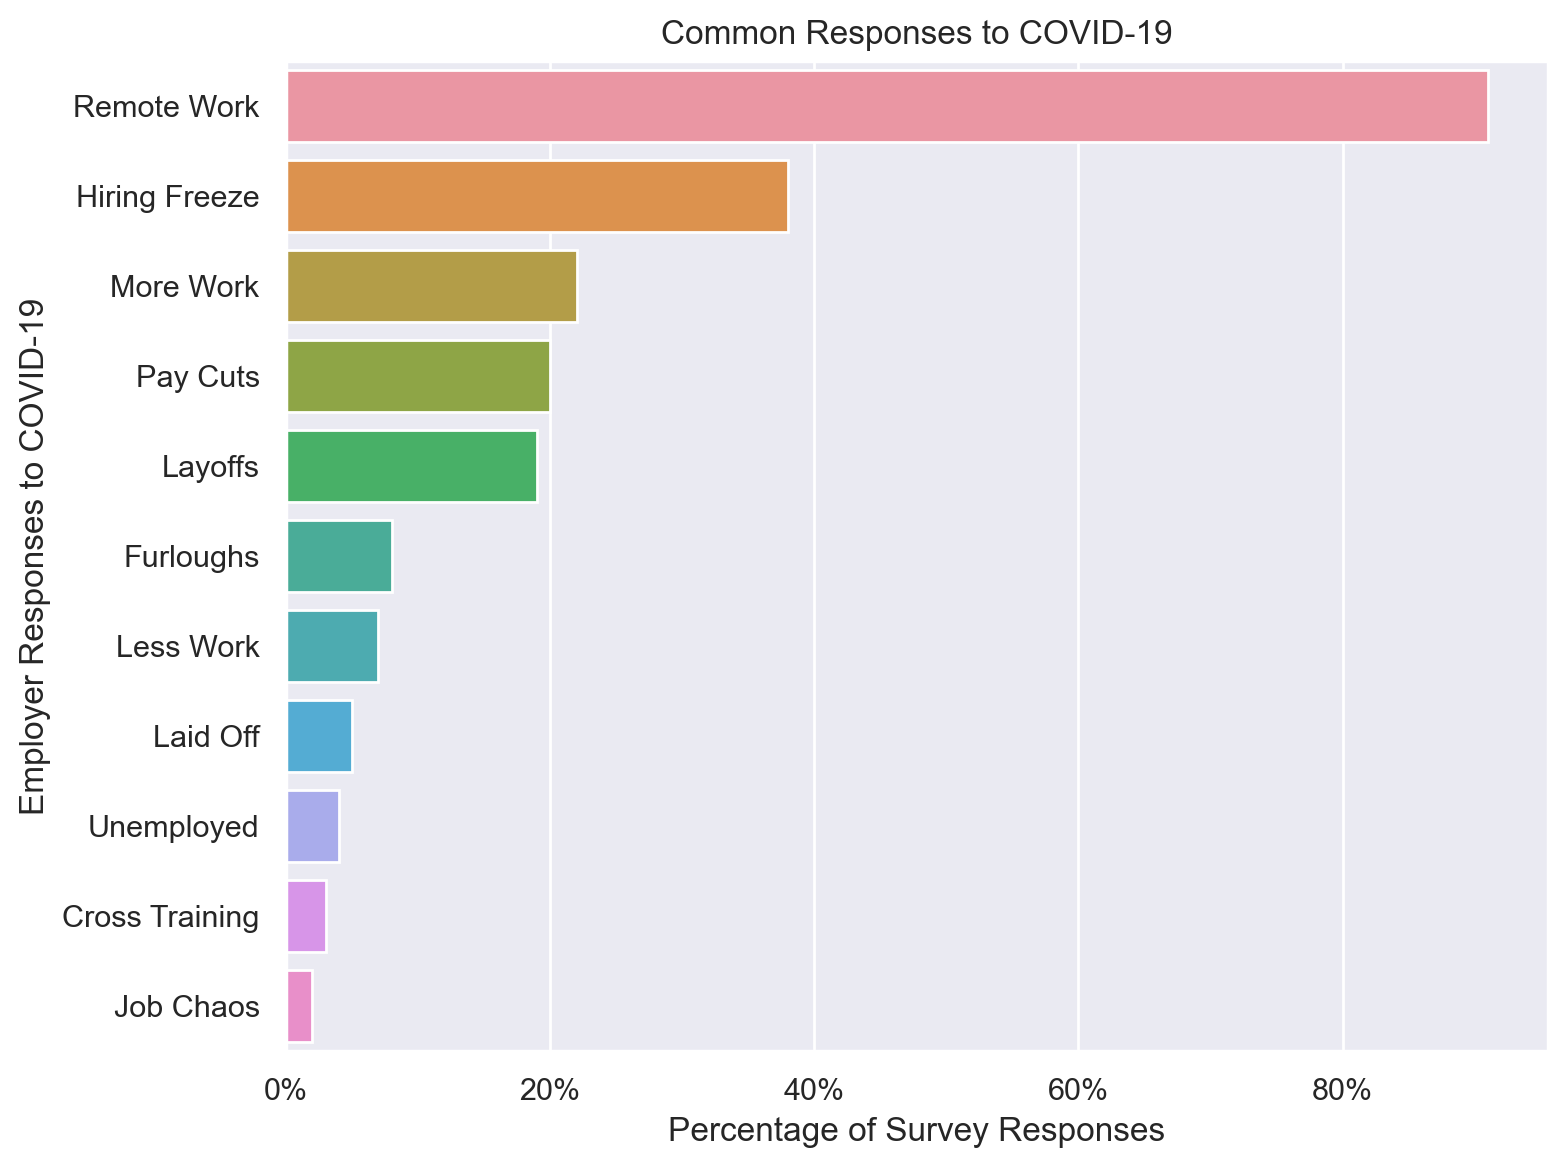

In [40]:
covid_labels = [
    "Remote Work",
    "Hiring Freeze",
    "More Work",
    "Pay Cuts",
    "Layoffs",
    "Furloughs",
    "Less Work",
    "Laid Off",
    "Unemployed",
    "Cross Training",
    "Job Chaos",
]
covid_percentages = [
    data['covid_remote'].mean() * 100,
    data['covid_no_hire'].mean() * 100,
    data['covid_more_work'].mean() * 100,
    data['covid_pay_cut'].mean() * 100,
    data['covid_layoffs'].mean() * 100,
    data['covid_furlough'].mean() * 100,
    data['covid_less_work'].mean() * 100,
    data['covid_laid_off'].mean() * 100,
    data['covid_unemployed'].mean() * 100,
    data['covid_cross_train'].mean() * 100,
    data['covid_chaotic'].mean() * 100,
]
covid_df = pd.DataFrame({'Response': covid_labels, 'Percentage':covid_percentages })

plt.figure(figsize=(8,6), dpi=200)
plot = sns.barplot(y="Response", x="Percentage", data=covid_df)
plot.xaxis.set_major_formatter(mtick.PercentFormatter())
plot.set(
    xlabel="Percentage of Survey Responses",
    ylabel="Employer Responses to COVID-19",
    title="Common Responses to COVID-19"
)
plt.tight_layout()
plot.get_figure().savefig("figures/covid.svg")
plt.show()
plt.close()

Overall, respondents were quite satisfied with their employers responses' to the COVID-19 pandemic, with nearly half giving their employers the highest possible score (7/7), and only two respondents indicating that they were some level of dissatistifed.

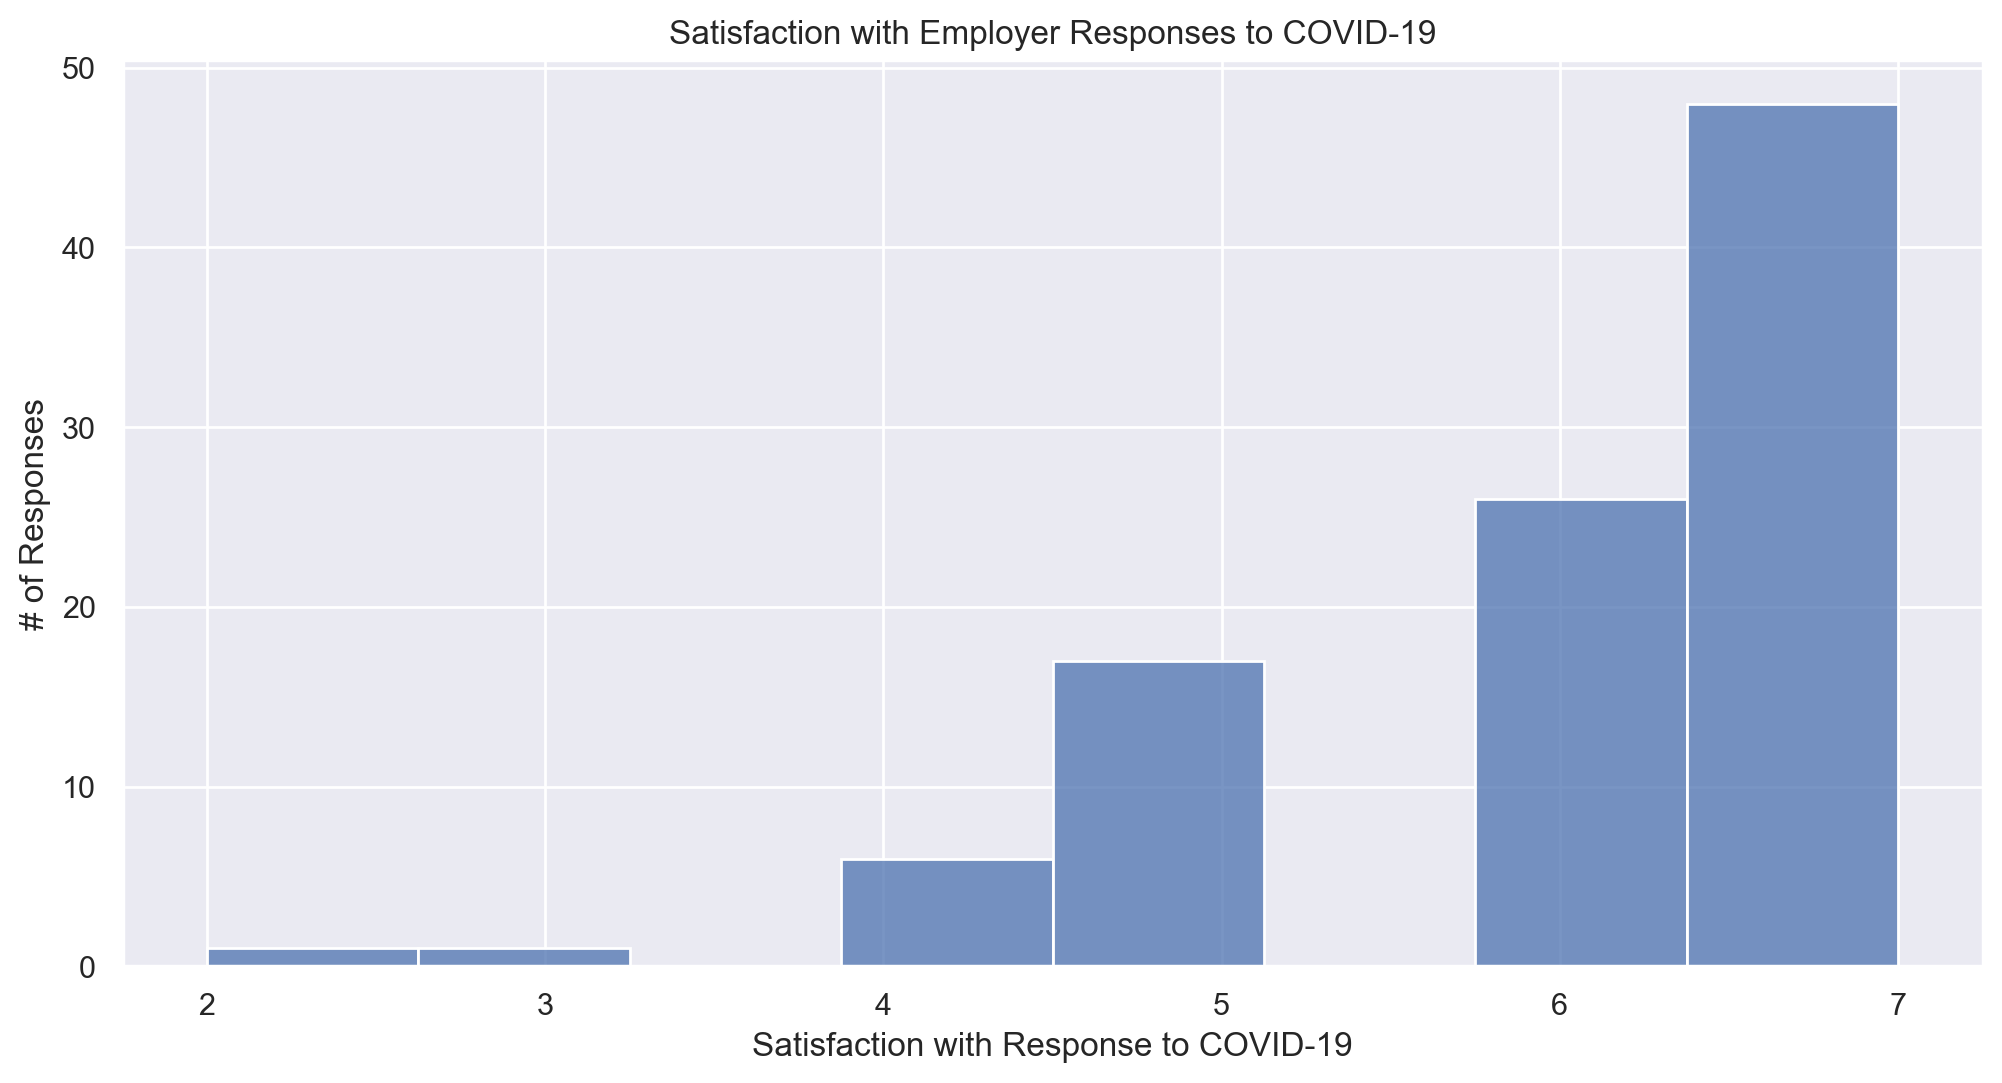

In [47]:
sns.set(color_codes=True)
plt.figure(figsize=(12,6), dpi=200)
plot = sns.histplot(data, x="covid_satisfied")
plot.set(
    xlabel="Satisfaction with Response to COVID-19",
    ylabel="# of Responses",
    title="Satisfaction with Employer Responses to COVID-19"
)
plot.get_figure().savefig("figures/covid_satisfaction.svg")
plt.show()
plt.close('all')

# Misc

While the data from this survey is _consistent_ with a "gender gap" in wages, there are significant limitations (e.g., the small sample size) that prevent us from making statistically reliable observations on this issue with this data.

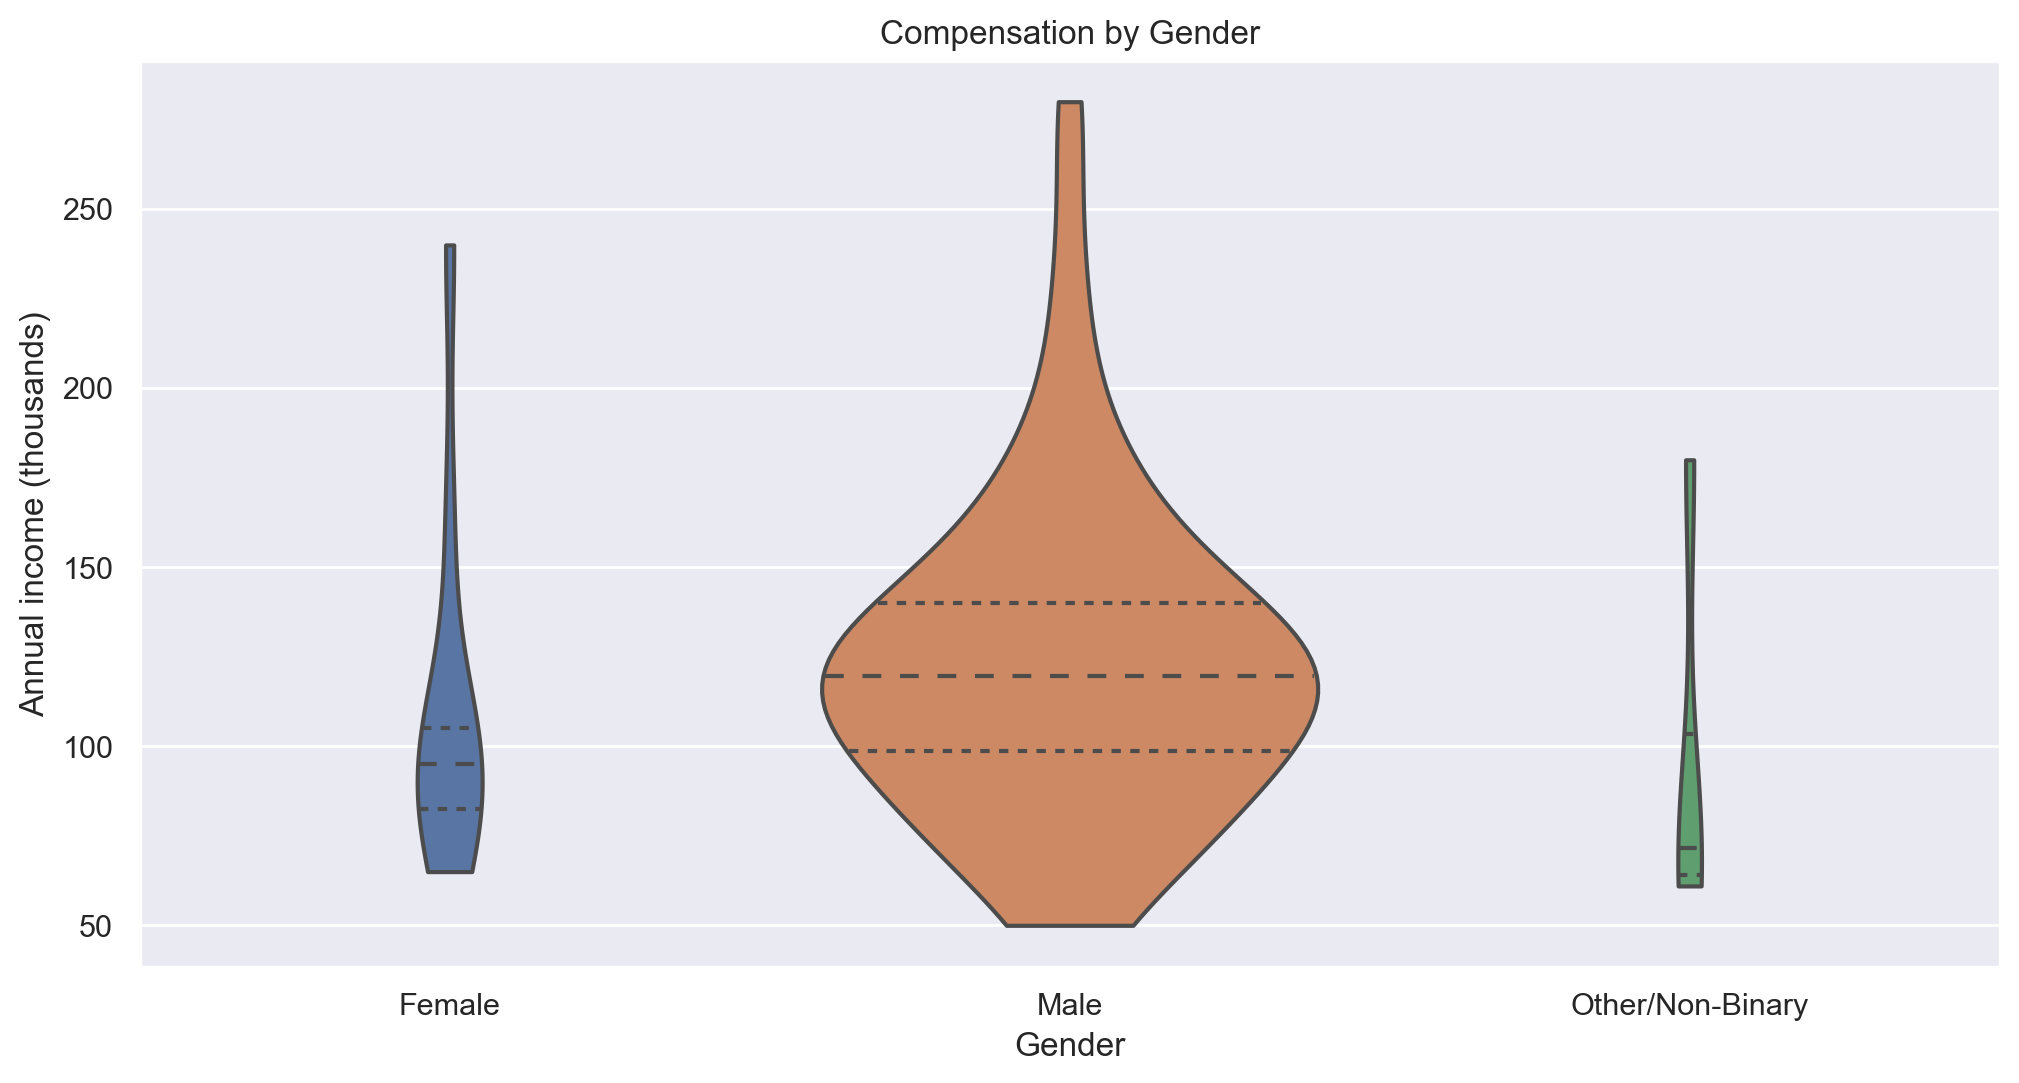

                            OLS Regression Results                            
Dep. Variable:                job_pay   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     10.89
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           3.26e-06
Time:                        22:51:45   Log-Likelihood:                -502.09
No. Observations:                  99   AIC:                             1012.
Df Residuals:                      95   BIC:                             1023.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [63]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "gender",
    y = "job_pay",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Gender",
    ylabel="Annual income (thousands)",
    title="Compensation by Gender"
)
plot.get_figure().savefig("figures/job_pay_vs_gender.svg")
plt.show()

model = sm.ols(formula="job_pay ~ gender", data=data)
result = model.fit();
print(result.summary())


A participant in our results discussion asked whether younger people were more likely to do remote work / telecommuting.  In fact, among the people who responded to the survey, the average remote worker had about 2.7 _more_ years of experience.  It was speculated that this might be because those with more experience have had more time to prove themselves and to establish relationships that might lead to these kinds of employment arrangements, but that this was an issue that could be interesting to investigate, due to the higher wages offered by these positions.

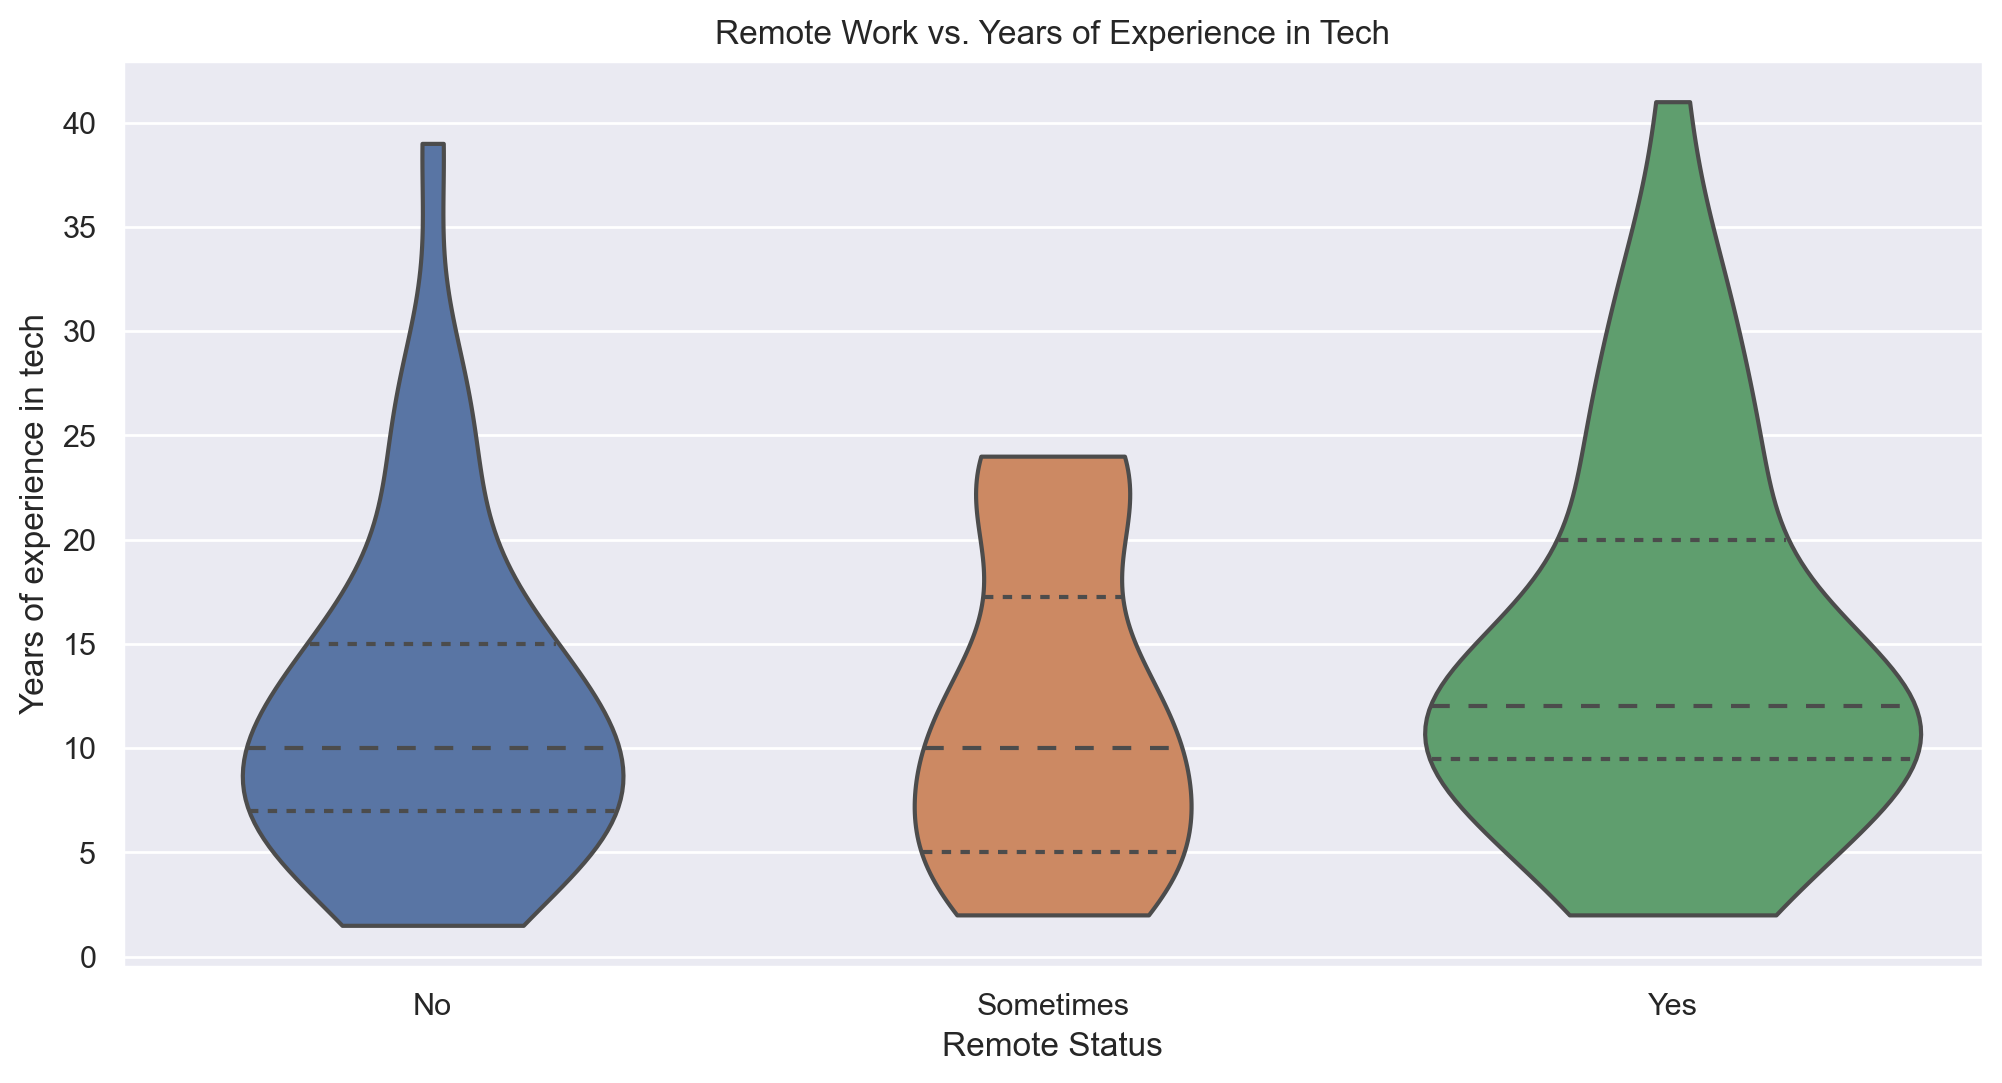

                            OLS Regression Results                            
Dep. Variable:            tech_tenure   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.339
Date:                Sun, 22 Nov 2020   Prob (F-statistic):              0.267
Time:                        22:58:39   Log-Likelihood:                -355.19
No. Observations:                 100   AIC:                             716.4
Df Residuals:                      97   BIC:                             724.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [66]:
plt.figure(figsize=(12,6), dpi=200)
plot = sns.violinplot(
    x = "job_remote",
    y = "tech_tenure",
    scale = "count", inner="quartile", bw=0.5, cut=0,
    # order = ["<=2", "3-5", "6-10", "11-15", "16-20", "20+"],
    data=data
)
plot.set(
    xlabel="Remote Status",
    ylabel="Years of experience in tech",
    title="Remote Work vs. Years of Experience in Tech"
)
plot.get_figure().savefig("figures/job_remote_vs_tech_tenure.svg")
plt.show()


model = sm.ols(formula="tech_tenure ~ job_remote", data=data)
result = model.fit();
print(result.summary())


Below are summary statistics for the entire data set.

In [68]:
data.describe()

,org_size,job_tenure,tech_tenure,tech_jobs,job_pay,job_when_negotiated,job_hours,job_vacation,side_job_pay,covid_satisfied,...,covid_laid_off,covid_more_work,covid_unemployed,misc_disability,misc_foreigner,misc_lgbt,misc_none,misc_parent,job_avg_tenure,log_org_size
count,98.000000,98.000000,100.000000,100.000000,100.000000,99.000000,99.000000,96.000000,28.000000,99.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.00,100.000000,98.000000
mean,5660.755102,3.443571,13.230000,5.660000,120.795000,2019.262626,41.505051,19.807292,8.857143,6.121212,...,0.050000,0.220000,0.040000,0.090000,0.020000,0.08000,0.470000,0.45,3.361844,2.517260
std,21232.560392,3.861666,8.598925,9.958723,44.817931,1.977351,5.630409,7.050707,10.800255,1.071645,...,0.219043,0.416333,0.196946,0.287623,0.140705,0.27266,0.501614,0.50,3.414788,1.146649
min,1.000000,0.000000,1.500000,1.000000,50.000000,2001.000000,20.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00,0.250000,0.000000
25%,50.000000,1.000000,7.000000,3.000000,88.000000,2019.000000,40.000000,15.000000,0.000000,5.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00,1.729167,1.698970
50%,200.000000,2.000000,11.000000,4.000000,115.000000,2020.000000,40.000000,20.000000,5.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00,2.500000,2.301030
75%,2375.000000,4.000000,17.000000,6.000000,140.000000,2020.000000,41.500000,25.000000,12.750000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.00,4.000000,3.373713
max,200000.000000,24.000000,41.000000,100.000000,280.000000,2020.000000,75.000000,40.000000,40.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00,24.000000,5.301030
